In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import itertools as it
import pickle
import os
import sympy as sp
from scipy.signal import peak_widths
from matplotlib import cm

import ccode.finite_system as tj
import ccode.tools as tl
import ccode.solvers as sl

import ccode.plotting as pt

%matplotlib inline

titles = ['left-right', 'left-center', 'center-right']
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
a = 10e-9

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [27]:
def max_phases(geometries, mu_qd0=0, npts=100, band=0):
    """
    Find optimal phases for a given geometry
    """

    eigen = sl.general_solver(geometries=geometries, n=6)
    phis = np.linspace(0, 2*np.pi, npts)


    def wrap(args):
        return eigen(*args)


    phases = sl.phase_params(key='mu_qd', param=mu_qd0, band_index=band)
    args = list(it.product(range(n_geometries), phases))
    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    maxs = []
    max_couplings = []

    data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
    for geometry in data_geometries:
        couplings, _, _ = tl.coupling_data(data=geometry, sign=1, prominence=0, n_peaks=1, n=40)
        maxs.append(phis[np.argmax(np.abs(couplings), axis=1)]/np.pi)
        max_couplings.append(couplings)

    maxs = np.array(maxs)
    max_couplings = np.array(max_couplings)
    return maxs

In [3]:
options = cluster_options()
options.worker_cores = 1
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction_design/"

# Triangular geometry with wires at one side angle

## Set up parameters

In [306]:
area = 1400*a**2
w = 7*a
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'down',
    "shape": 'triangle',
    "A": area
}

In [307]:
n_geometries = 50
angles = np.linspace(0.05, 0.3, n_geometries)

In [308]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/triangle_angles_one_side/'

## Calculation

In [287]:
tjs = []
for theta in angles:
    geometry.update(angle=theta*np.pi)
    center = np.sqrt(np.abs(area/np.tan(theta*np.pi)))/2
    if center < 3*w/2:
        center = 10*a
    geometry.update(centers=[center, -center])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

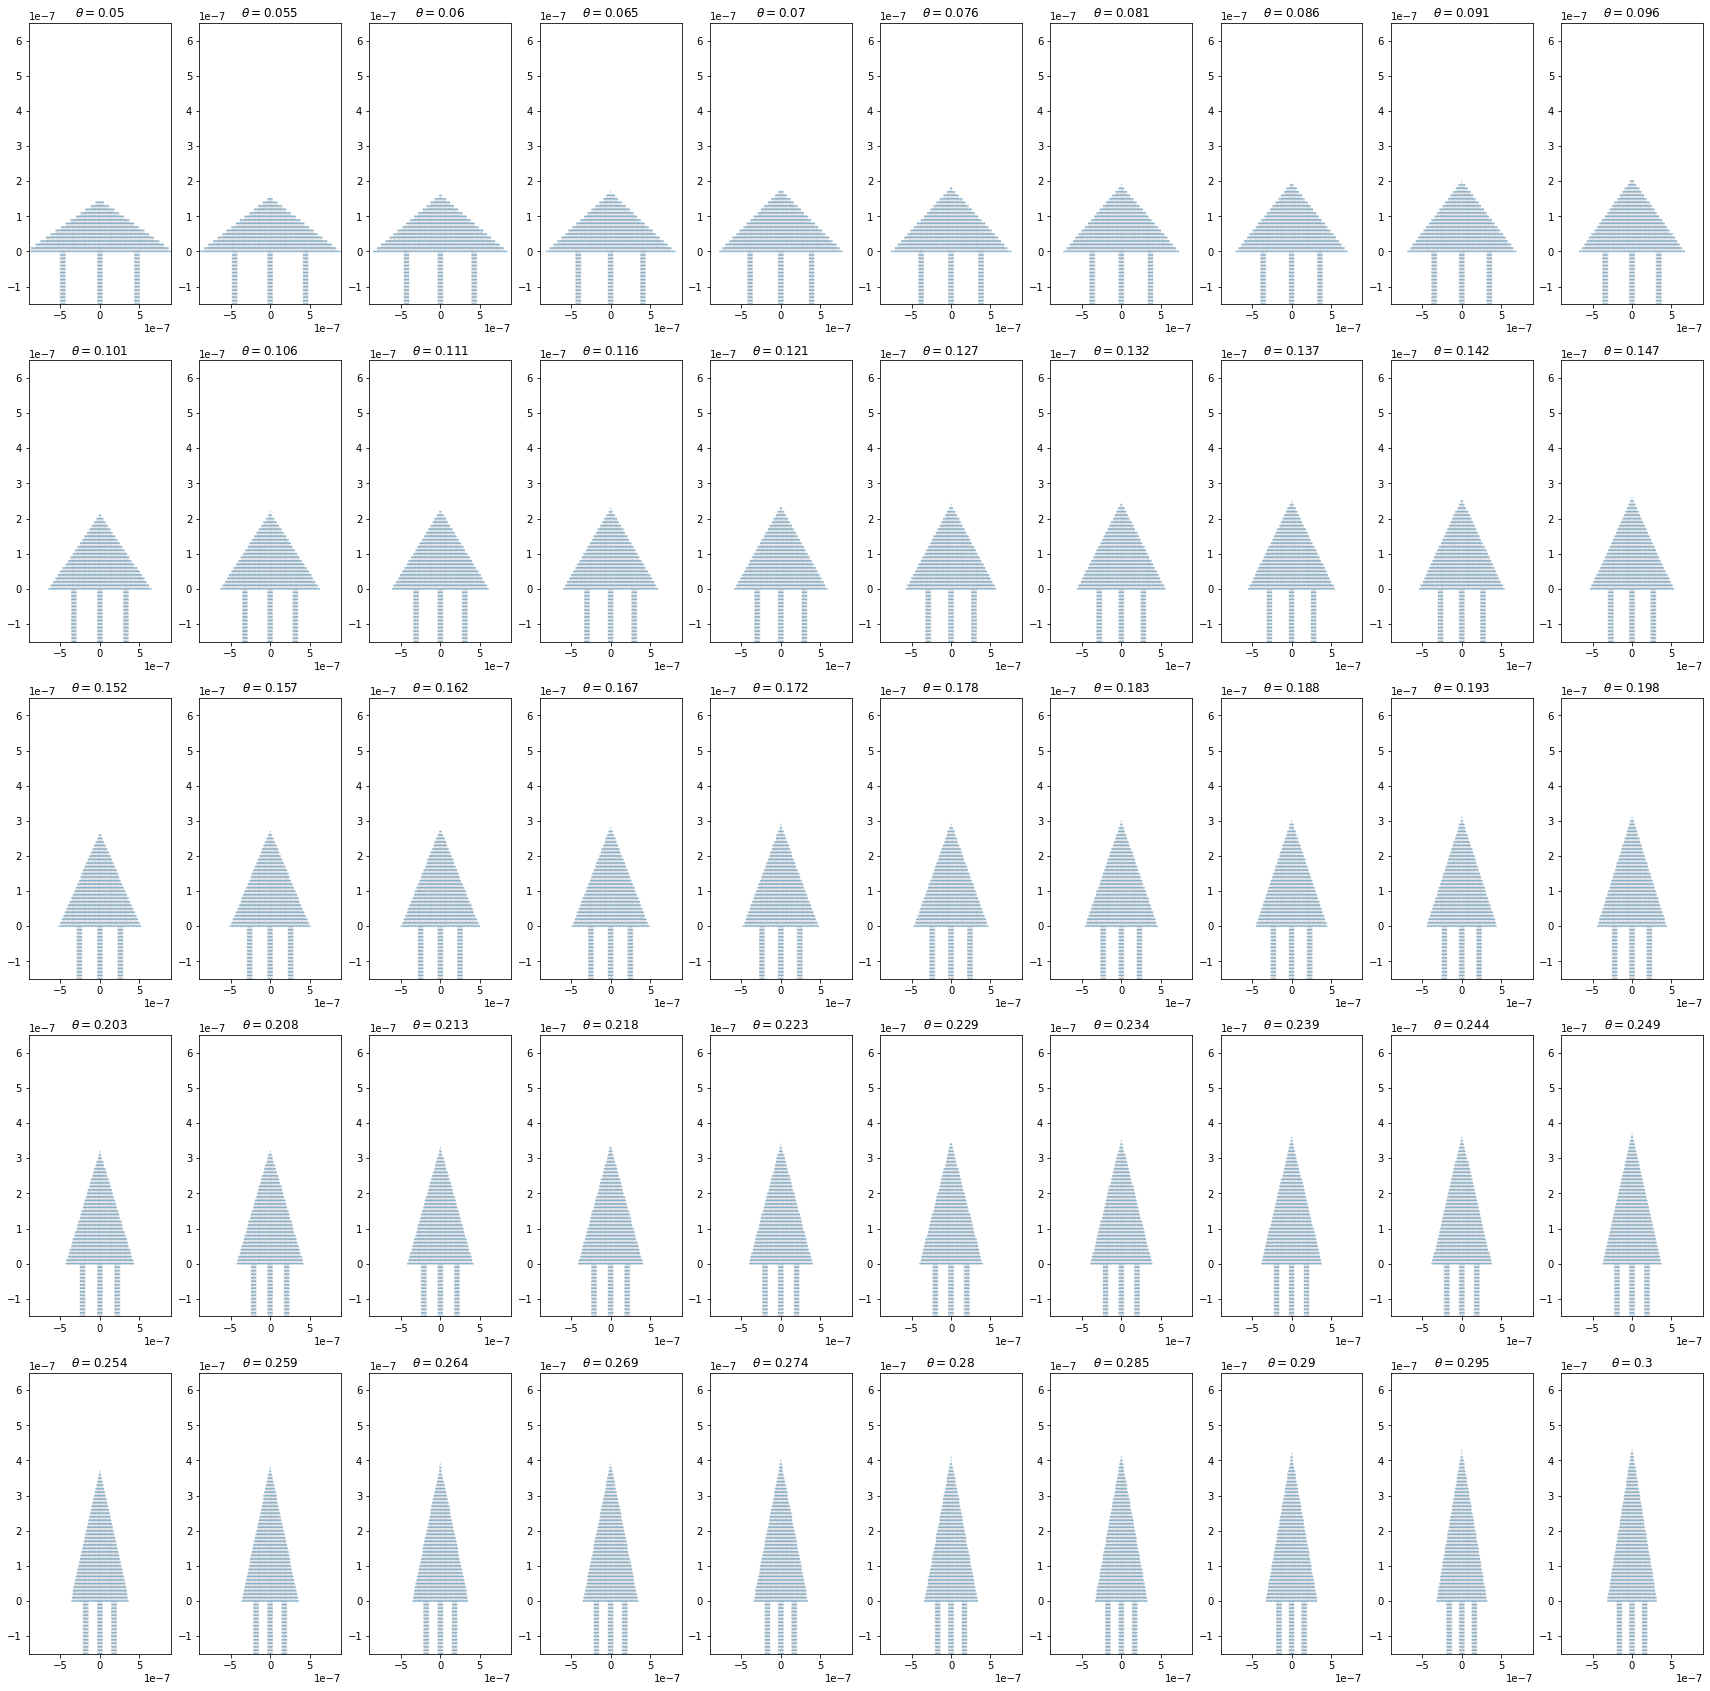

In [288]:
fig, ax = plt.subplots(ncols=int(n_geometries/5), nrows=5, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 6.5e-7)
    axes.set_xlim(-9e-7, 9e-7)
    axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [289]:
%%time
max_phis = max_phases(geometries=tjs)
path = directory_path + '/area_1400_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/b3e2a45bce42459292cb306591a70941/status
CPU times: user 2min 52s, sys: 6.69 s, total: 2min 59s
Wall time: 11min 14s


In [311]:
path = directory_path + 'area_1200_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

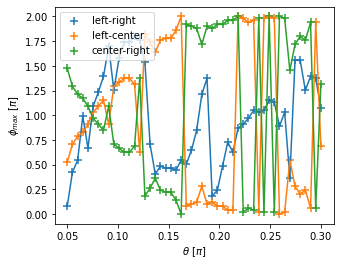

In [312]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(angles, level)
    ax.scatter(angles, level, label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper left')
plt.savefig(directory_path+'triangle_one_side_phase_relation.pdf')

In [292]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [293]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/triangle_angles_one_side/’: File exists


256

In [294]:
%%time

index = 0 # single band calculation
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)


with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/fd3e17daf2544f0c81d5bd6925797eaa/status
CPU times: user 2min 52s, sys: 7.95 s, total: 3min
Wall time: 13min 44s


In [106]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)
        result = args_db.map(wrap).compute()

        path = directory_path + '/area_900_band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/ef1a312f22144dd9bf5667a7f1323548/status
CPU times: user 8min 24s, sys: 15.4 s, total: 8min 40s
Wall time: 47min 14s


## Selected cases

### $\theta = 0.234 \pi$

In [314]:
area = 1200*a**2
theta = angles[36]
w = 7*a
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'down',
    "shape": 'triangle',
    "A": area,
    "angle": theta*np.pi
}

center = np.sqrt(np.abs(area/np.tan(theta*np.pi)))/2
geometry.update(centers=[center, -center])

In [315]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


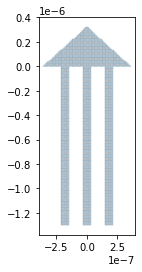

In [316]:
kwant.plot(trijunction);

In [317]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-0.001, 0.001, 100)

In [318]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [319]:
%%time
# execute calculation
index = 0
phis = np.pi*max_phis[36]
params = sl.finite_coupling_parameters(index=index, phis=phis)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_a_234.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/7c8a0cc5394c48f7975c5adecd842e80/status
CPU times: user 6.19 s, sys: 2.14 s, total: 8.33 s
Wall time: 2min 26s


# Triangular geometry with wires at one side size

## Set up parameters

In [70]:
angle = np.pi/4
w = 7*a
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'down',
    "shape": 'triangle',
    "angle": angle
}

In [82]:
n_geometries = 25
areas = np.linspace(700, 3700, n_geometries)

In [95]:
areas

array([ 700.,  825.,  950., 1075., 1200., 1325., 1450., 1575., 1700.,
       1825., 1950., 2075., 2200., 2325., 2450., 2575., 2700., 2825.,
       2950., 3075., 3200., 3325., 3450., 3575., 3700.])

In [90]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/triangle_angles_one_side_size/'

In [91]:
os.system('mkdir '+directory_path)

0

## Calculation

In [84]:
tjs = []
for area in areas:
    geometry.update(A=area*a**2)
    center = np.sqrt(np.abs(area*a**2/np.tan(angle)))/2
    if center < 3*w/2:
        center = 10*a
    geometry.update(centers=[center, -center])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

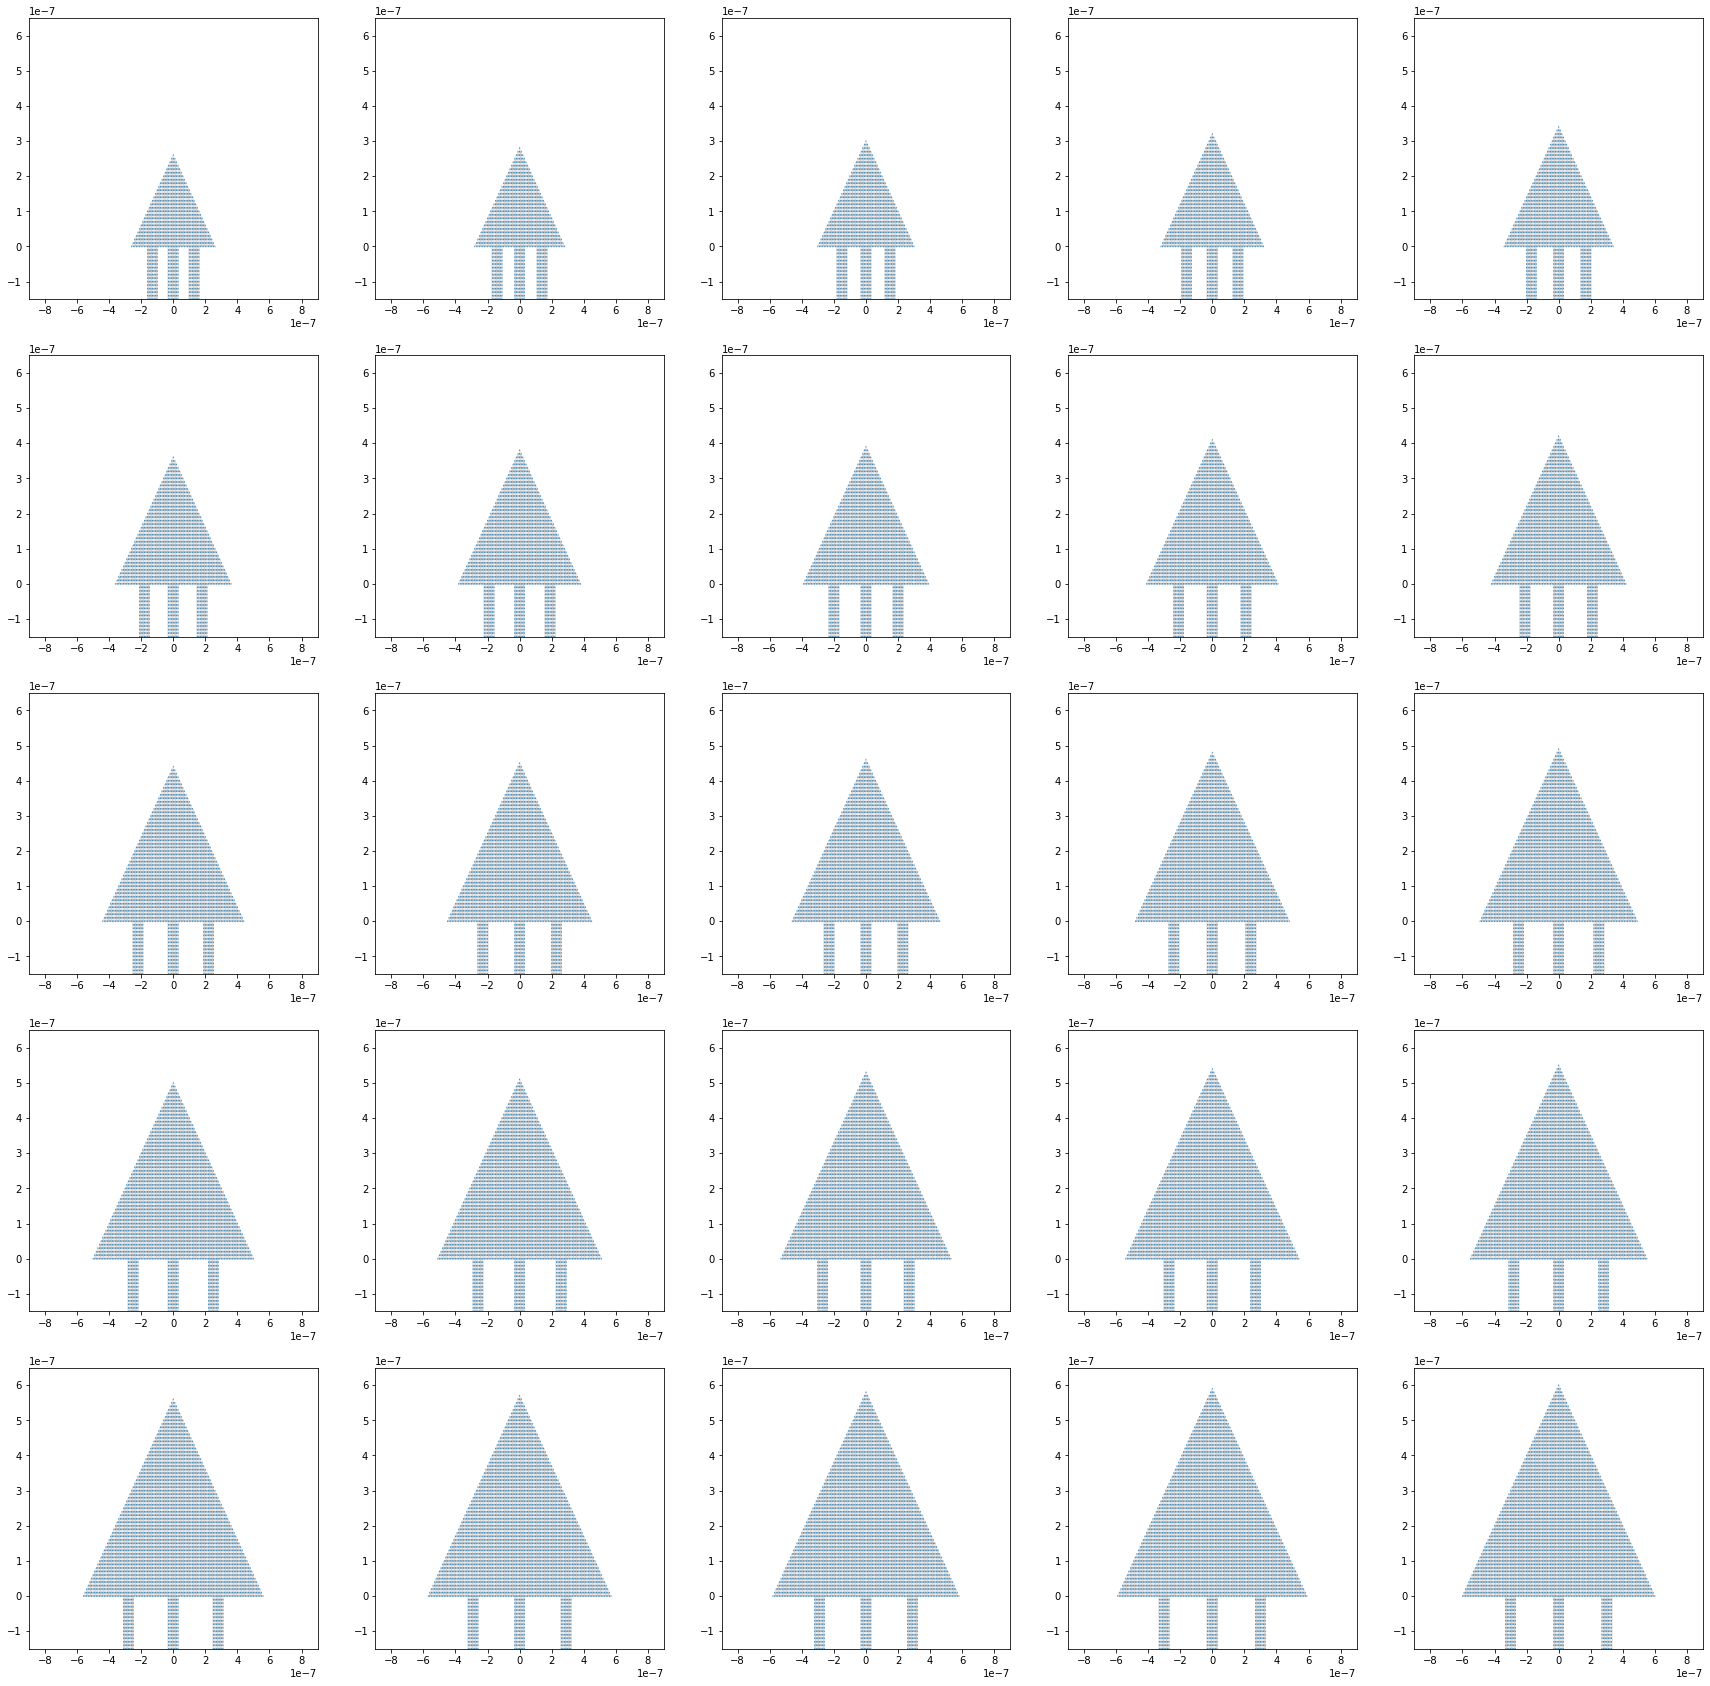

In [85]:
fig, ax = plt.subplots(ncols=int(n_geometries/5), nrows=5, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 6.5e-7)
    axes.set_xlim(-9e-7, 9e-7)
    #axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [86]:
max_phis = max_phases(geometries=tjs)
path = directory_path + '/phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/6a1a6a41c7774da9ae6f311f4a406d22/status


In [88]:
path = directory_path + 'phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

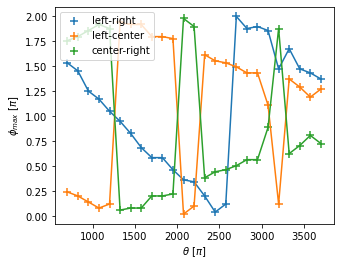

In [92]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(areas, level)
    ax.scatter(areas, level, label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper left')
plt.savefig(directory_path+'triangle_one_side_phase_relation.pdf')

In [93]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [311]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/triangle_angles_one_side/’: File exists


256

In [170]:
%%time

index = 0 # single band calculation
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)


with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

In [94]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)

        result = args_db.map(wrap).compute()

        path = directory_path + '/band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/3446ab19ccef4ce3a9153a8e4be2e13a/status
CPU times: user 9min 49s, sys: 18.7 s, total: 10min 8s
Wall time: 1h 2min 12s


# Inverted triangular geometry with wires at both side

## Set up parameters

In [674]:
area = 1400*a**2
geometry = {
    "L": 130*a,
    "w": 7*a,
    "side": 'up',
    "area": area
}

In [675]:
n_geometries = 25
angles = np.linspace(0.05, 0.3, n_geometries)

In [676]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/inverted_triangle_angles_one_side/'

In [677]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/inverted_triangle_angles_one_side/’: File exists


256

## Calculation

In [11]:
tjs = []
for angle in angles:
    geometry.update(angle=angle*np.pi)
    trijunction, f_params = tj.inverted_triangle_junction(**geometry)
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

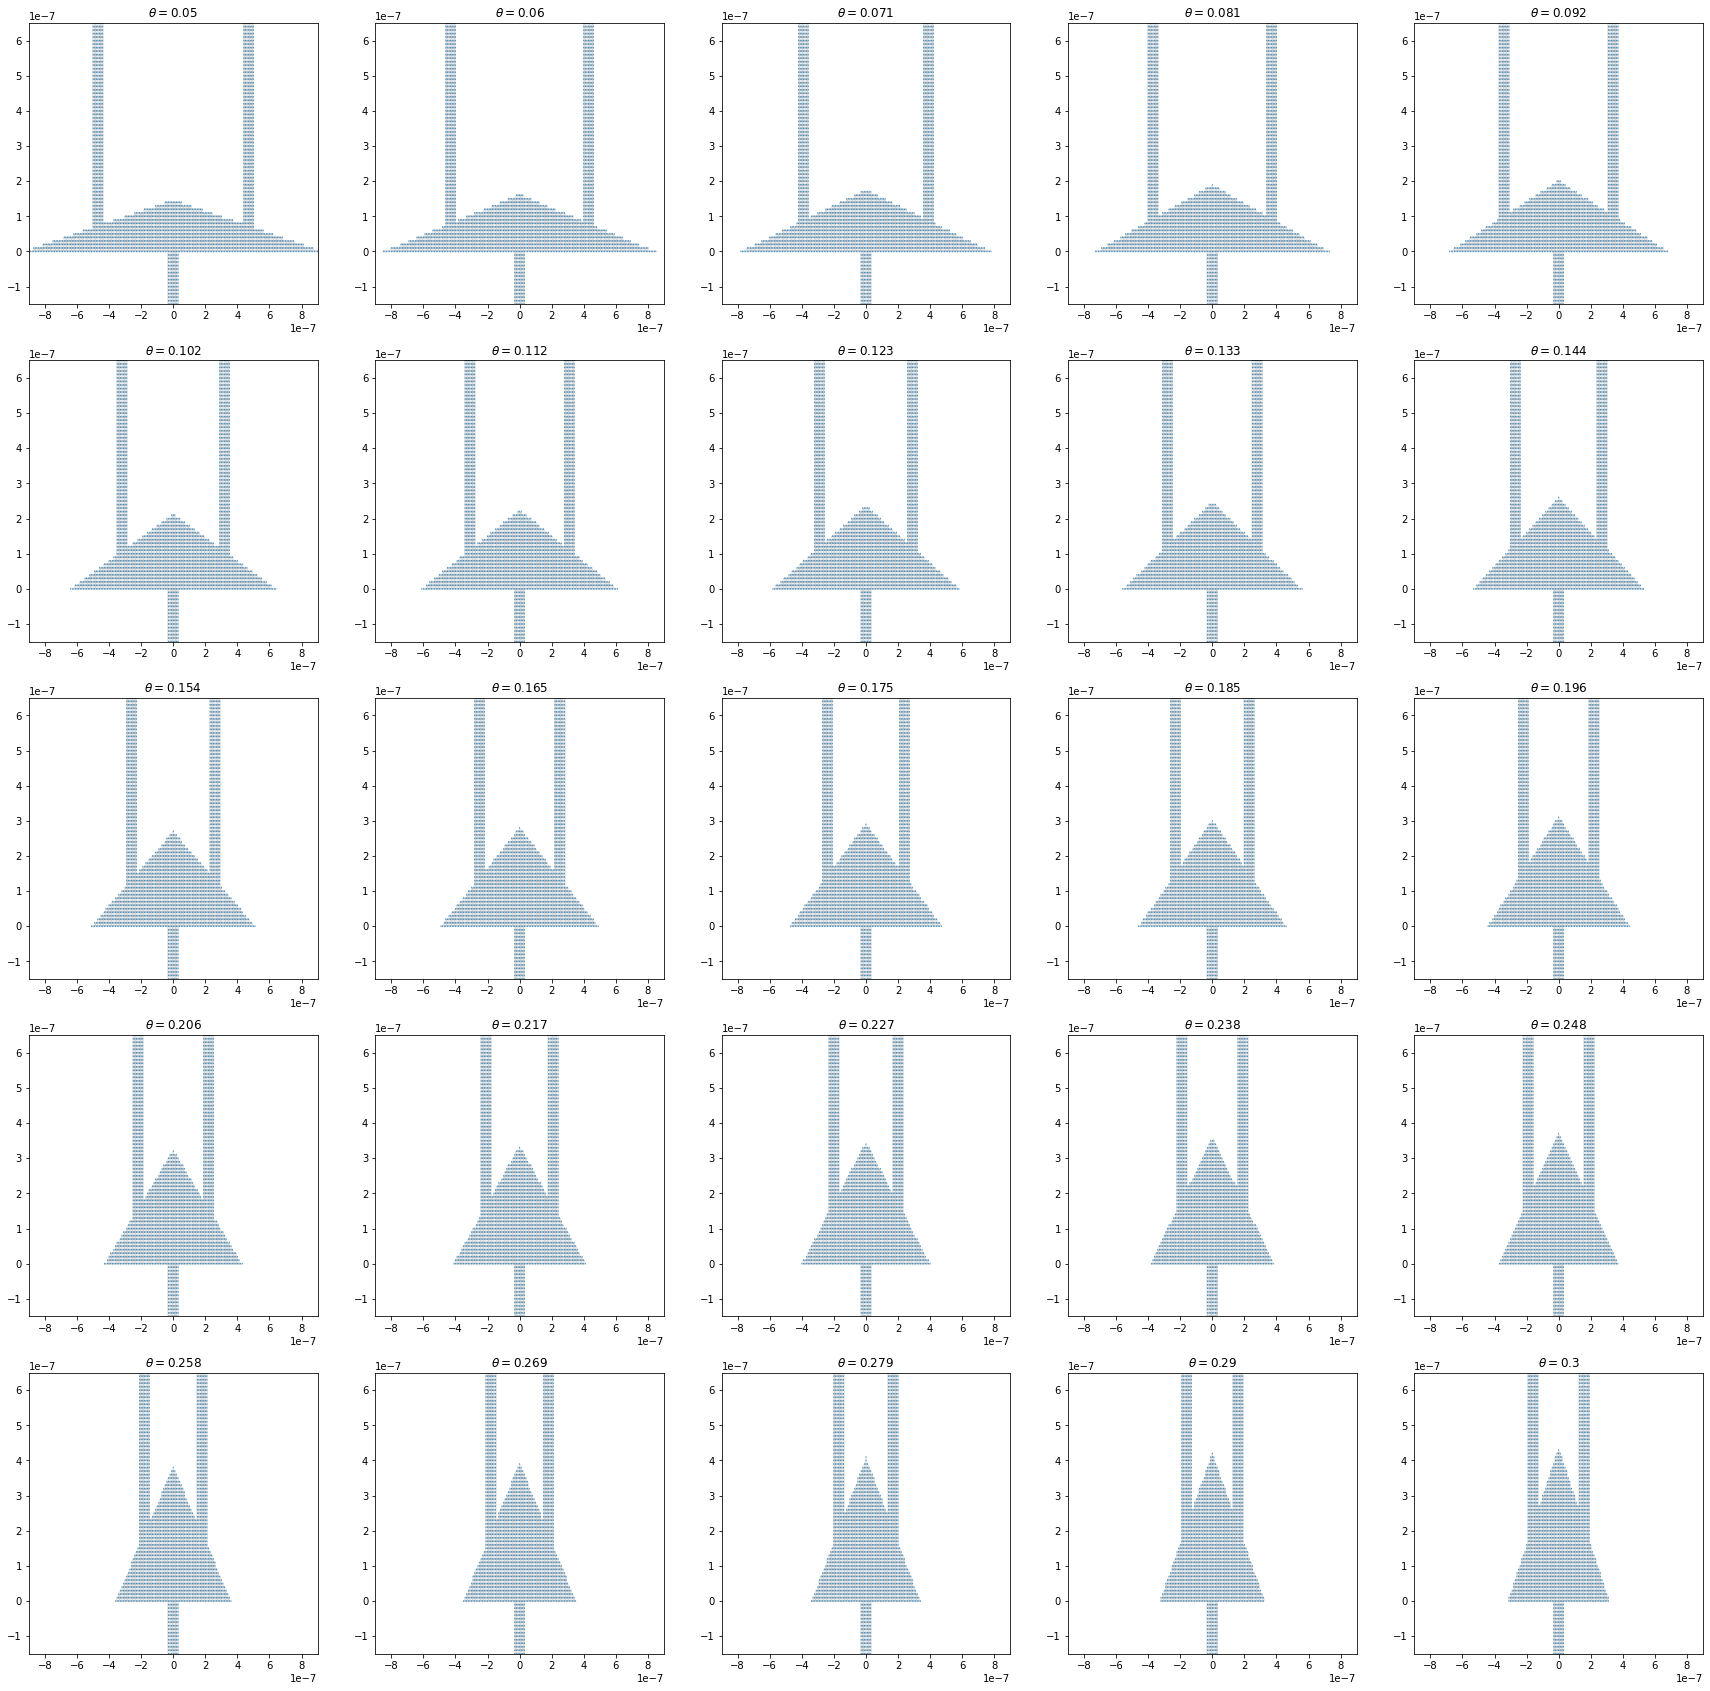

In [12]:
fig, ax = plt.subplots(ncols=int(n_geometries/5), nrows=5, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 6.5e-7)
    axes.set_xlim(-9e-7, 9e-7)
    axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [204]:
max_phis = max_phases(geometries=tjs, band=2)
path = directory_path + '/area_1400_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/8f1c38cdfaac4b8eb5134cecda7779b2/status


In [644]:
path = directory_path + 'area_1400_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

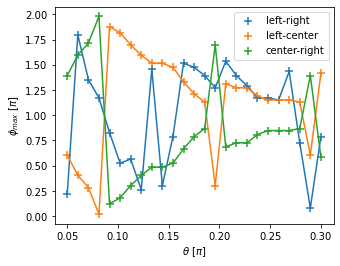

In [645]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(angles, level)
    ax.scatter(angles, level, label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper right')
plt.savefig(directory_path+'inverted_triangle_two_side_phase_relation.pdf')

In [15]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [16]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/inverted_triangle_angles_one_side/’: File exists


256

In [170]:
%%time

index = 0 # single band calculation
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)


with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

In [17]:
%%time
for index in range(4, 7):

    args = []

    for i in range(n_geometries):
        for mu in mus_qd:
            for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                args.append([i, mu, param])

    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
    with open(path, 'wb') as file:
        pickle.dump(result, file)

Dashboard MBS coupling band 4: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/868f04c6f1584911a96e17cc3a000e4b/status
Dashboard MBS coupling band 5: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/8e9f25e3bcb74914be20f19df84a09eb/status
Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/4265952443874991b551c1595c1690be/status
CPU times: user 3min 41s, sys: 4.98 s, total: 3min 46s
Wall time: 26min 15s


# Inverted triangular geometry with wires at one side

## Set up parameters

In [663]:
area = 1400*a**2
geometry = {
    "L": 130*a,
    "w": 7*a,
    "side": 'down',
    "area": area
}

In [664]:
n_geometries = 25
angles = np.linspace(0.05, 0.3, n_geometries)

In [665]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/inverted_triangle_angles_both_side/'

In [666]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/inverted_triangle_angles_both_side/’: File exists


256

## Calculation

In [226]:
tjs = []
for angle in angles:
    geometry.update(angle=angle*np.pi)
    trijunction, f_params = tj.inverted_triangle_junction(**geometry)
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

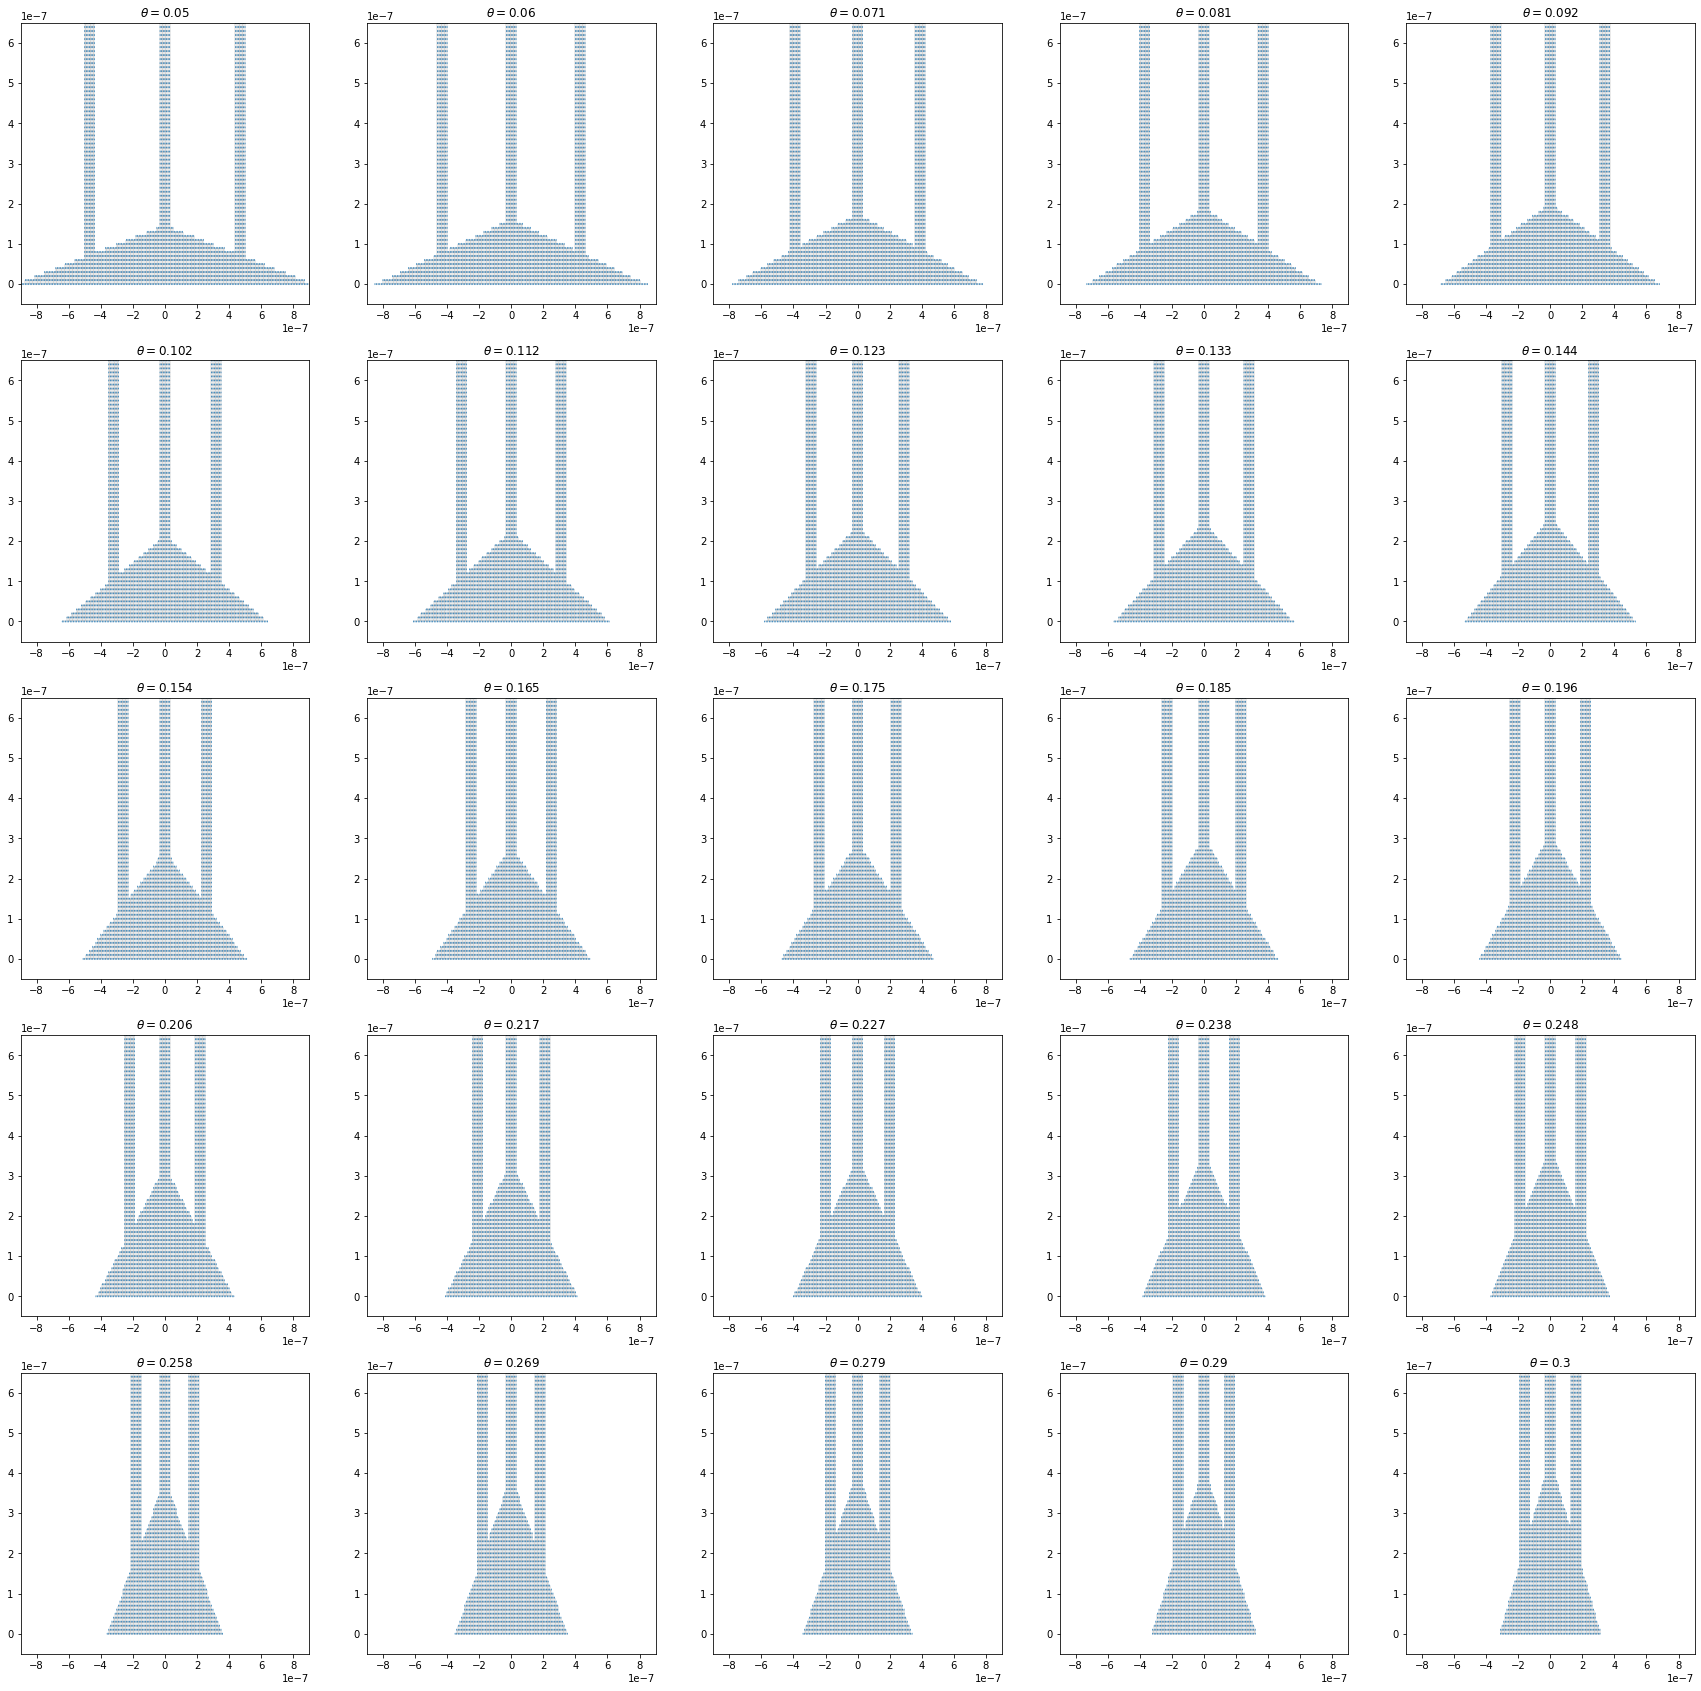

In [227]:
fig, ax = plt.subplots(ncols=int(n_geometries/5), nrows=5, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-.5e-7, 6.5e-7)
    axes.set_xlim(-9e-7, 9e-7)
    axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [228]:
max_phis = max_phases(geometries=tjs, band=2)
path = directory_path + '/area_1400_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/a197f180af124653b40a1deff563fb1e/status


In [231]:
path = directory_path + 'area_1400_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

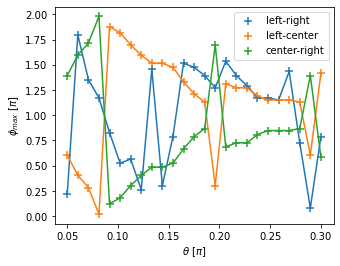

In [671]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(angles, level)
    ax.scatter(angles, level, label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper right')
plt.savefig(directory_path+'inverted_triangle_one_side_phase_relation.pdf')

In [233]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [234]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/inverted_triangle_angles_both_side/’: File exists


256

In [170]:
%%time

index = 0 # single band calculation
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)


with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

In [235]:
%%time
for index in range(7):

    args = []

    for i in range(n_geometries):
        for mu in mus_qd:
            for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                args.append([i, mu, param])

    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
    with open(path, 'wb') as file:
        pickle.dump(result, file)

Dashboard MBS coupling band 0: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/8717b6d919824671bdf99fca8b82ea25/status
Dashboard MBS coupling band 1: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/b0bd7c786a134d83b748ffc9b4776144/status
Dashboard MBS coupling band 2: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/773280fb57e040a5bcd2a23ae31d9d1c/status
Dashboard MBS coupling band 3: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/86fe178f83a4442cb73a31a77be1f1c2/status
Dashboard MBS coupling band 4: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/3f2eeaf322e14c68a4c22f249cf2fcf4/status
Dashboard MBS coupling band 5: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/84f6e9145cf2412d801670c143a1d09b/status
Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/55712788e9734d47a708da9d90da1671/status
CPU ti

# Triangular geometry with wires at both sides

## Set up parameters

In [320]:
area = 1400*a**2
w = 7*a
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'up',
    "shape": 'triangle',
    "A": area
}

In [321]:
n_geometries = 50
angles = np.linspace(0.05, 0.3, n_geometries)

In [322]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/triangle_angles_two_side/'

## Calculation

In [298]:
tjs = []
for theta in angles:
    geometry.update(angle=theta*np.pi)
    center = np.sqrt(np.abs(area/np.tan(theta*np.pi)))/2
    if center < 3*w/2:
        center = 10*a
    geometry.update(centers=[center, -center])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

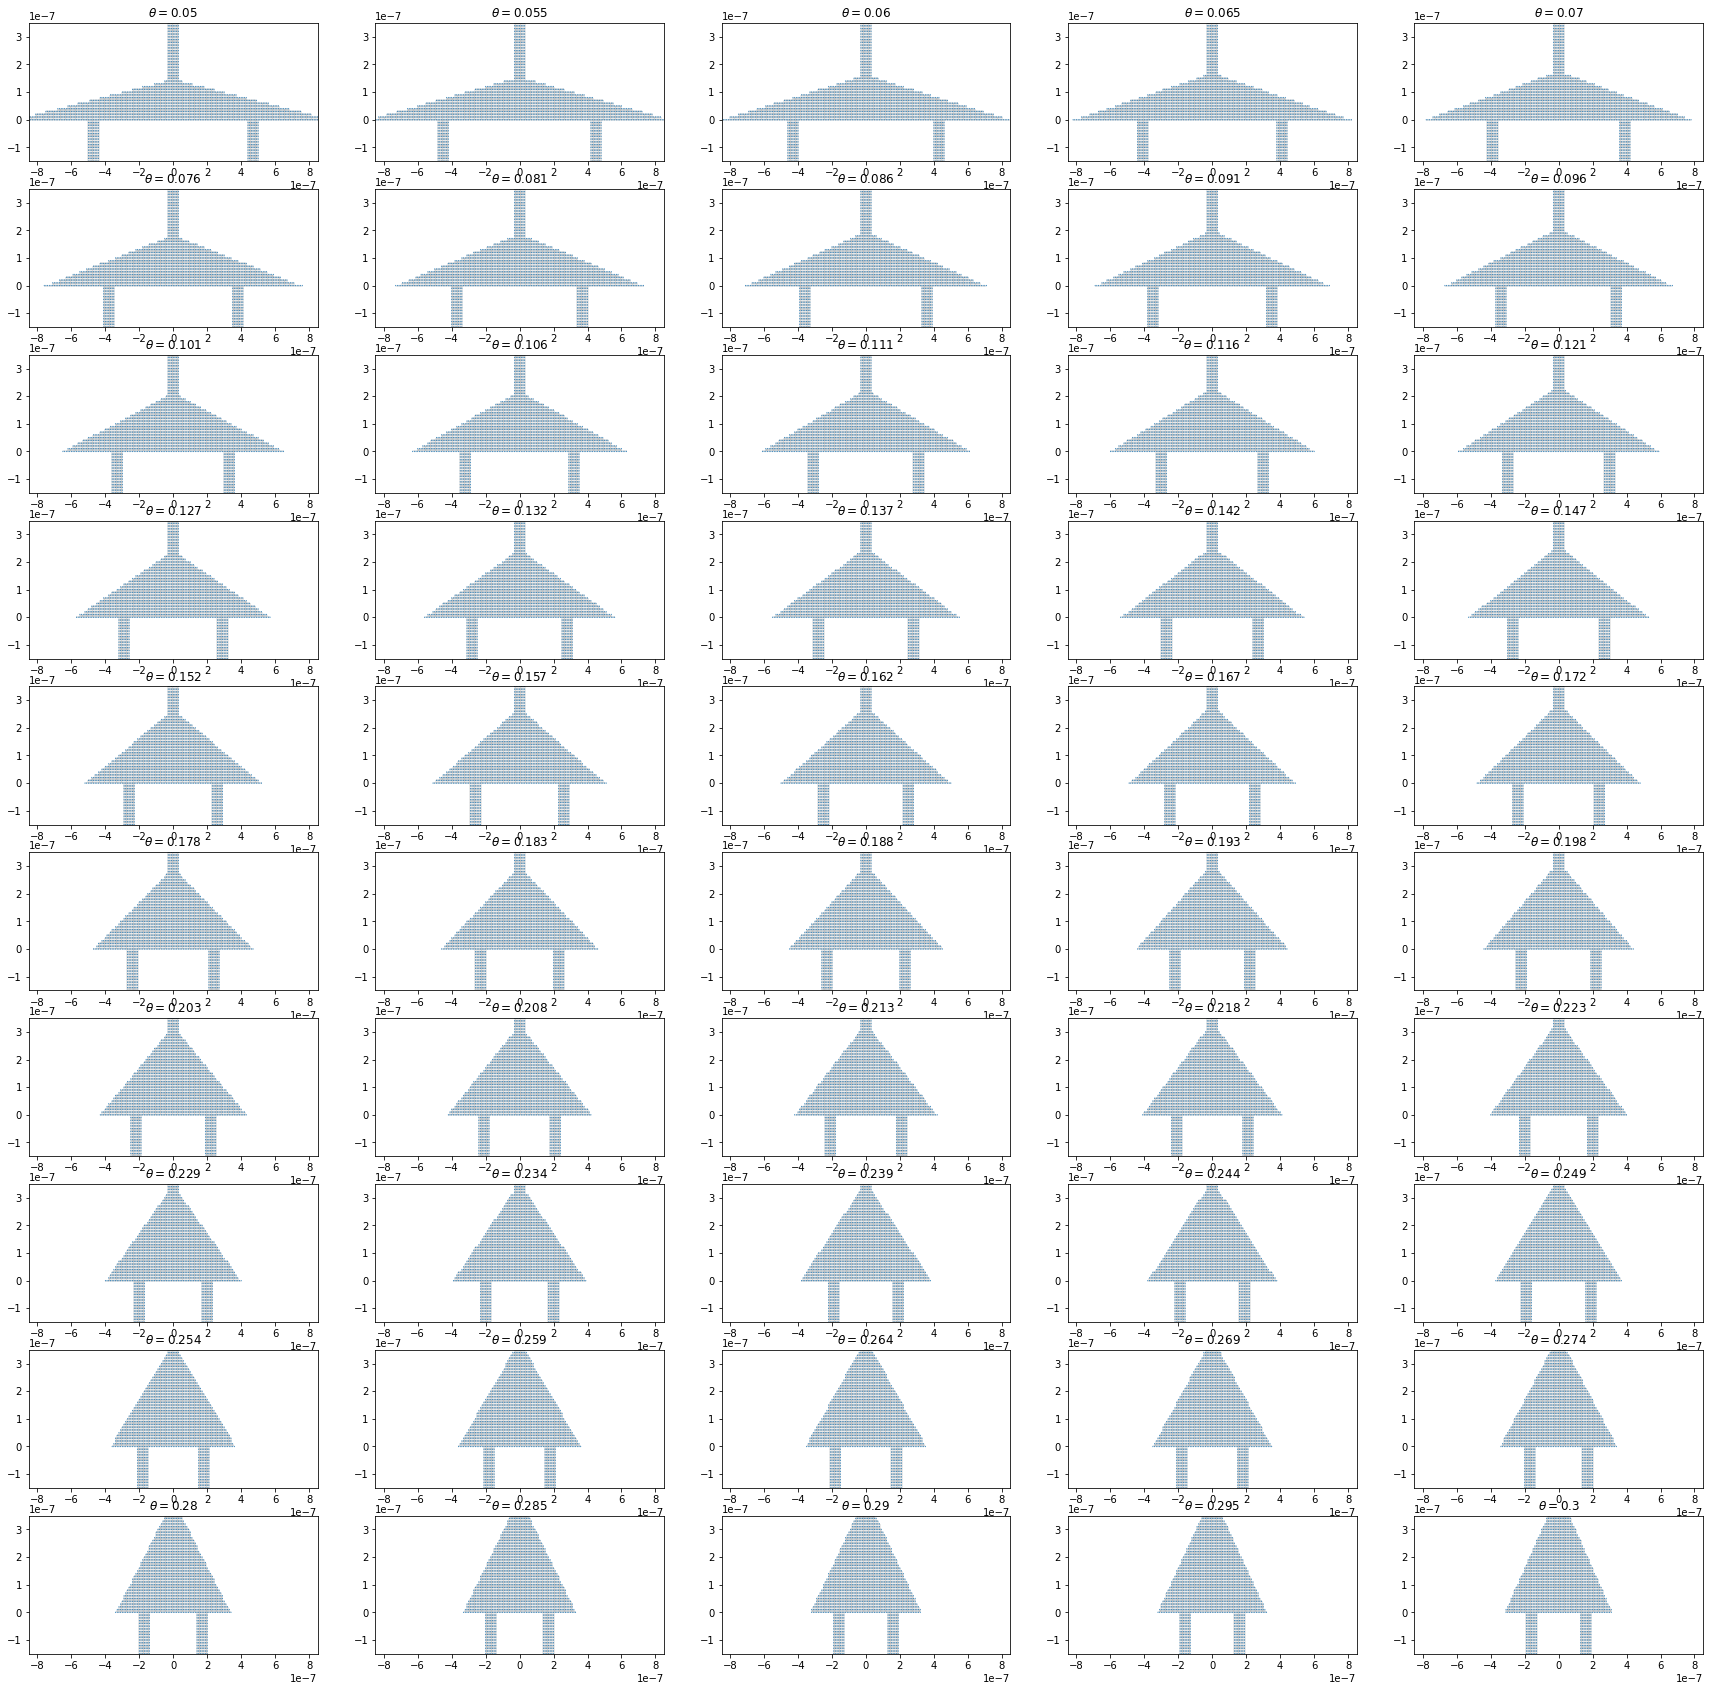

In [299]:
fig, ax = plt.subplots(ncols=int(n_geometries/10), nrows=10, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 3.5e-7)
    axes.set_xlim(-8.5e-7, 8.5e-7)
    axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [300]:
result = max_phases(geometries=tjs)
path = directory_path + '/area_1400_phis_50.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/bf048666b7194eb4b88854ba4cd178dd/status


In [323]:
path = directory_path + '/area_1200_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

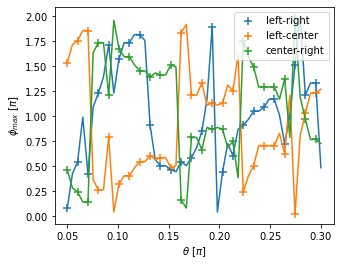

In [324]:
#i = 0
#for level in max_phis_0.T:
#    plt.plot(angles, level, label=titles[i])
 #   i += 1
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(angles, level)
    ax.scatter(angles[::2], level[::2], label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper right')
plt.savefig(directory_path+'triangle_two_side_phase_relation.pdf')

In [303]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [304]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/triangle_angles_two_side/’: File exists


256

In [305]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/d98f3bf95bff480596a6a6cca51f06ca/status


In [117]:
%%time
with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)
        result = args_db.map(wrap).compute()

        path = directory_path + '/area_900_band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/22099cb1bdd54a90af964b53f620140a/status
CPU times: user 8min 24s, sys: 13.2 s, total: 8min 37s
Wall time: 46min 40s


## Selected cases

### $\theta = 0.096 \pi$

In [325]:
area = 1200*a**2
w = 7*a
theta = angles[7]
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'up',
    "shape": 'triangle',
    "A": area,
    "angle": theta*np.pi
}

center = np.sqrt(np.abs(area/np.tan(theta*np.pi)))/2
geometry.update(centers=[center, -center])

In [326]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


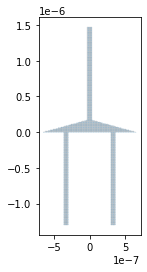

In [327]:
kwant.plot(trijunction);

In [328]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-0.001, 0.001, 100)

In [329]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [330]:
%%time
# execute calculation
index = 0
phis = np.pi*max_phis[7]
params = sl.finite_coupling_parameters(index=index, phis=phis)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_a_086.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/1267e7da92a4471aa643c806cfc70dab/status
CPU times: user 5.93 s, sys: 2.42 s, total: 8.36 s
Wall time: 2min 23s


### $\theta = 0.096 \pi$

In [770]:
area = 1400*a**2
w = 7*a
theta = angles[9]
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'up',
    "shape": 'triangle',
    "A": area,
    "angle": theta*np.pi
}

center = np.sqrt(np.abs(area/np.tan(theta*np.pi)))/2
geometry.update(centers=[center, -center])

In [771]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


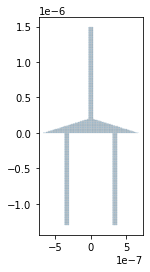

In [772]:
kwant.plot(trijunction);

In [773]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-0.001, 0.001, 100)

In [774]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [775]:
%%time
# execute calculation
index = 0
phis = np.pi*max_phis[9]
params = sl.finite_coupling_parameters(index=index, phis=phis)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_a_096.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/05ffb1c258ab436fbe29ec45c0af7418/status
CPU times: user 6.26 s, sys: 2.94 s, total: 9.2 s
Wall time: 2min 43s


# Triangular geometry with wires at both sides size

## Set up parameters

In [127]:
angle = np.pi/4
w = 7*a
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'up',
    "shape": 'triangle',
    "angle": angle
}

In [128]:
n_geometries = 25
areas = np.linspace(700, 3700, n_geometries)

In [129]:
areas

array([ 700.,  825.,  950., 1075., 1200., 1325., 1450., 1575., 1700.,
       1825., 1950., 2075., 2200., 2325., 2450., 2575., 2700., 2825.,
       2950., 3075., 3200., 3325., 3450., 3575., 3700.])

In [130]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/triangle_angles_two_side_size/'

In [131]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/triangle_angles_two_side_size/’: File exists


256

## Calculation

In [134]:
tjs = []
for area in areas:
    geometry.update(A=area*a**2)
    center = np.sqrt(np.abs(area*a**2/np.tan(angle)))/2
    if center < 3*w/2:
        center = 10*a
    geometry.update(centers=[center, -center])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

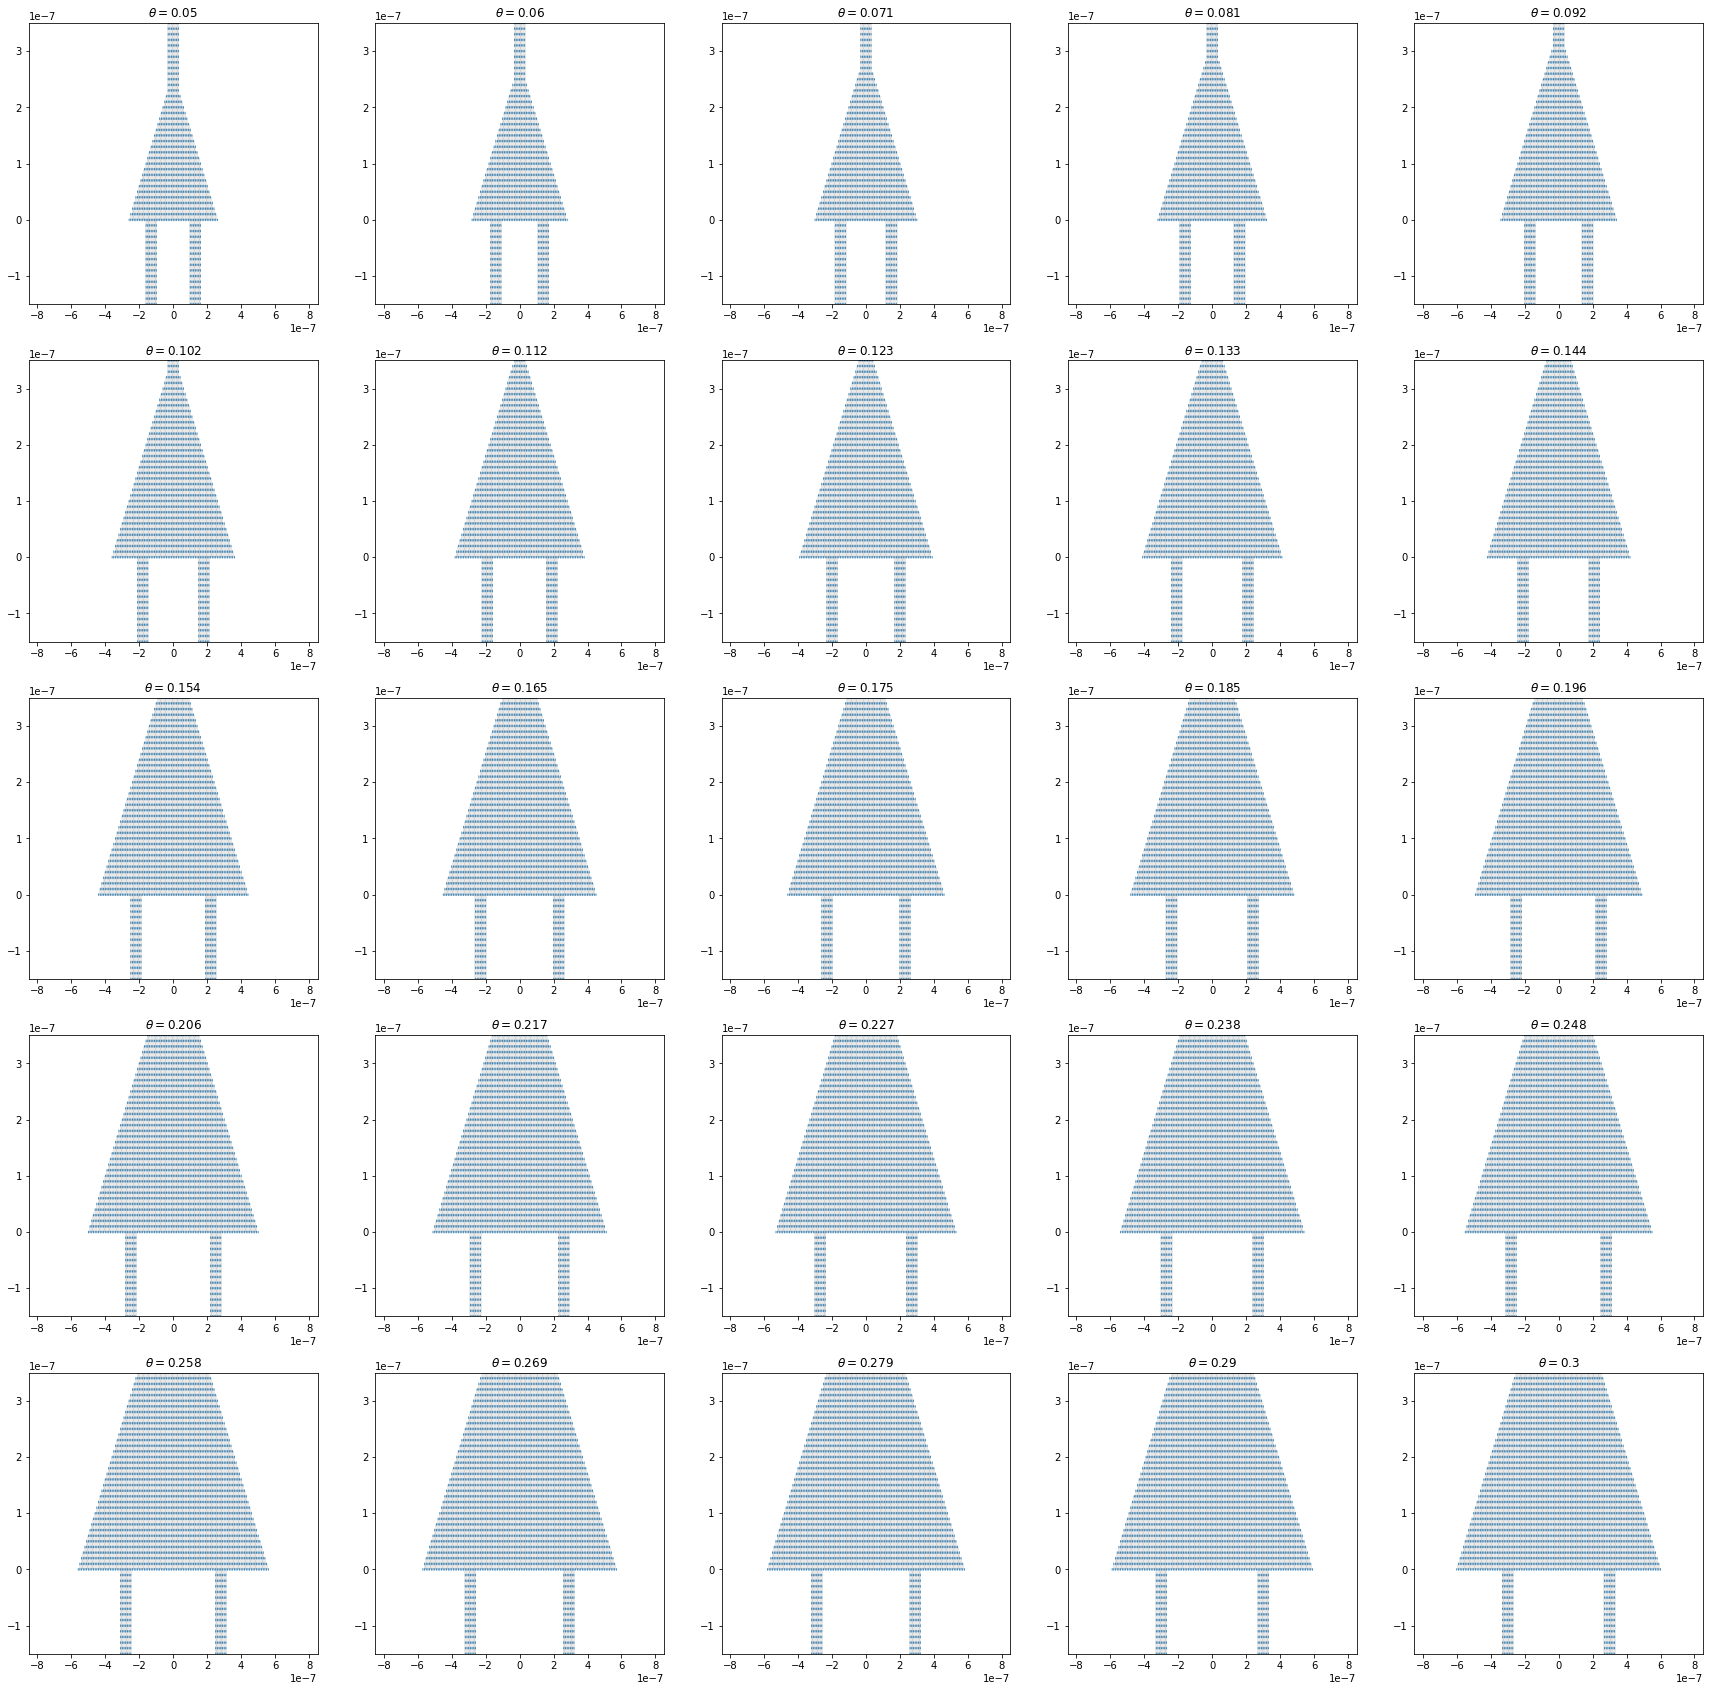

In [135]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 3.5e-7)
    axes.set_xlim(-8.5e-7, 8.5e-7)
    axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [136]:
result = max_phases(geometries=tjs)
path = directory_path + '/phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/315576c3a214483b8895d7b0d658635a/status


In [137]:
path = directory_path + '/phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

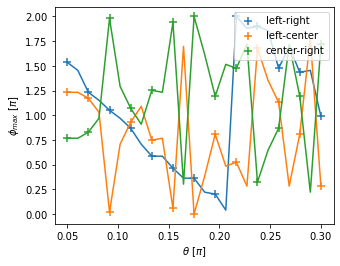

In [138]:
#i = 0
#for level in max_phis_0.T:
#    plt.plot(angles, level, label=titles[i])
 #   i += 1
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(angles, level)
    ax.scatter(angles[::2], level[::2], label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper right')
plt.savefig(directory_path+'triangle_two_side_phase_relation.pdf')

In [139]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [171]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/triangle_angles_two_side/’

256

: File exists


In [22]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=50)

with Cluster(options) as cluster:
    cluster.scale(n=50)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/area_1200_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/5d68017d7fbc4e1b98fec7a61d3c57ac/status


In [140]:
%%time
with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)
        result = args_db.map(wrap).compute()

        path = directory_path + '/area_900_band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/b48fcf9fb17e4585833463ed726fd57b/status
CPU times: user 10min 21s, sys: 28.2 s, total: 10min 50s
Wall time: 1h 3min


# Half ring cavity

## Set up parameters

In [1034]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'ring',
}

In [1035]:
n_geometries = 50
rads = np.linspace([6*a, 21*a], [91*a, 106*a], n_geometries)

In [1036]:
mus_qd = np.linspace(-0.001, 0.003, 200)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/half_ring/'

## Calculation

In [267]:
tjs = []
for r, R in rads:
    geometry.update(r=r)
    geometry.update(R=R)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

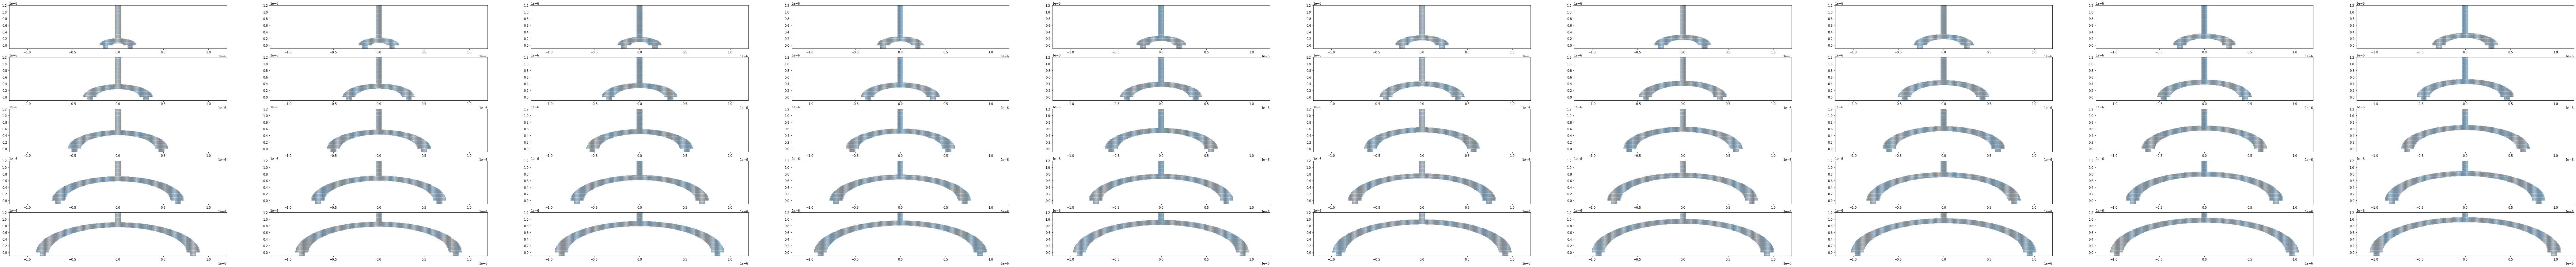

In [268]:
fig, ax = plt.subplots(ncols=int(n_geometries/5), nrows=5, figsize=(3*n_geometries, 15))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1e-7, 12e-7)
    axes.set_xlim(-12e-7, 12e-7)
    i += 1

In [195]:
max_phis = max_phases(geometries=tjs)
path = directory_path + '/width_15_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/323f60474328447fb376b395c08c6c3f/status


In [473]:
path = directory_path + '/width_15_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

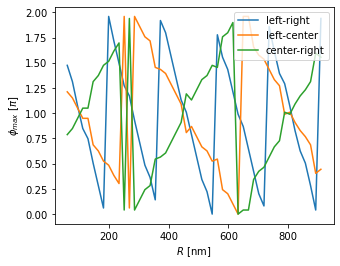

In [479]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(1e9*rads[:, 0], level, label=titles[i])
    i += 1
ax.set_xlabel(r'$R$ [nm]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper right')

plt.savefig(directory_path+'ring_phase_relation.pdf')

In [271]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [272]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/half_ring/’: File exists


256

In [367]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)

In [368]:
len(args)

30000

In [369]:
%%time
with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/width_15_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/f8bd40642c4447e381164b02c0fd3dc0/status
CPU times: user 3min 16s, sys: 14.7 s, total: 3min 31s
Wall time: 25min 9s


In [273]:
%%time
for index in range(7):

    args = []

    for i in range(n_geometries):
        for mu in mus_qd:
            for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                args.append([i, mu, param])

    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    path = directory_path + '/width_15_band_'+str(index)+'th.pickle'
    with open(path, 'wb') as file:
        pickle.dump(result, file)

Dashboard MBS coupling band 0: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/381d8a75ee824da2989440766cab0aef/status
Dashboard MBS coupling band 1: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/88de88c53b884eda9232903153c2117b/status
Dashboard MBS coupling band 2: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/153605d114c448fd89a0ef91d0f715df/status
Dashboard MBS coupling band 3: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/cb67db0499bc4080bdc186d53b84a22c/status
Dashboard MBS coupling band 4: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/faf94a0d7caf450bab0599869f055d9f/status
Dashboard MBS coupling band 5: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/51dd5af0b57342f0bc2bde2c63850551/status
Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/56aa91c2f2f24f60a56f51b01c750c9a/status
CPU ti

## Wavefunctions for selected cases

### $R = 400$ [nm] and $W = 110$ [nm]

In [447]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'ring',
    "R": 4.12857143e-07,
    "r": 3.02857143e-07
}

In [448]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


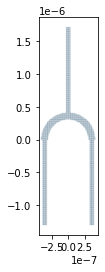

In [449]:
kwant.plot(trijunction);

In [434]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-0.001, 0.002, 100)

In [357]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [113]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_R_260.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/9bf5b4f12351436c950dad2368989649/status


# Y shaped cavity size

In [141]:
angle = np.pi*0.23
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": 0*a,
    "w_v": 15*a
}

In [142]:
n_geometries = 50
areas = np.linspace(500, 3000, n_geometries)
geometries=areas

In [143]:
mus_qd = np.linspace(-1e-3, 3e-3, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/y_shaped/'

In [144]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/y_shaped/’: File exists


256

## Calculationdirectory_path

In [145]:
tjs = []
for i in range(n_geometries):
    geometry.update(A=areas[i]*a**2)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

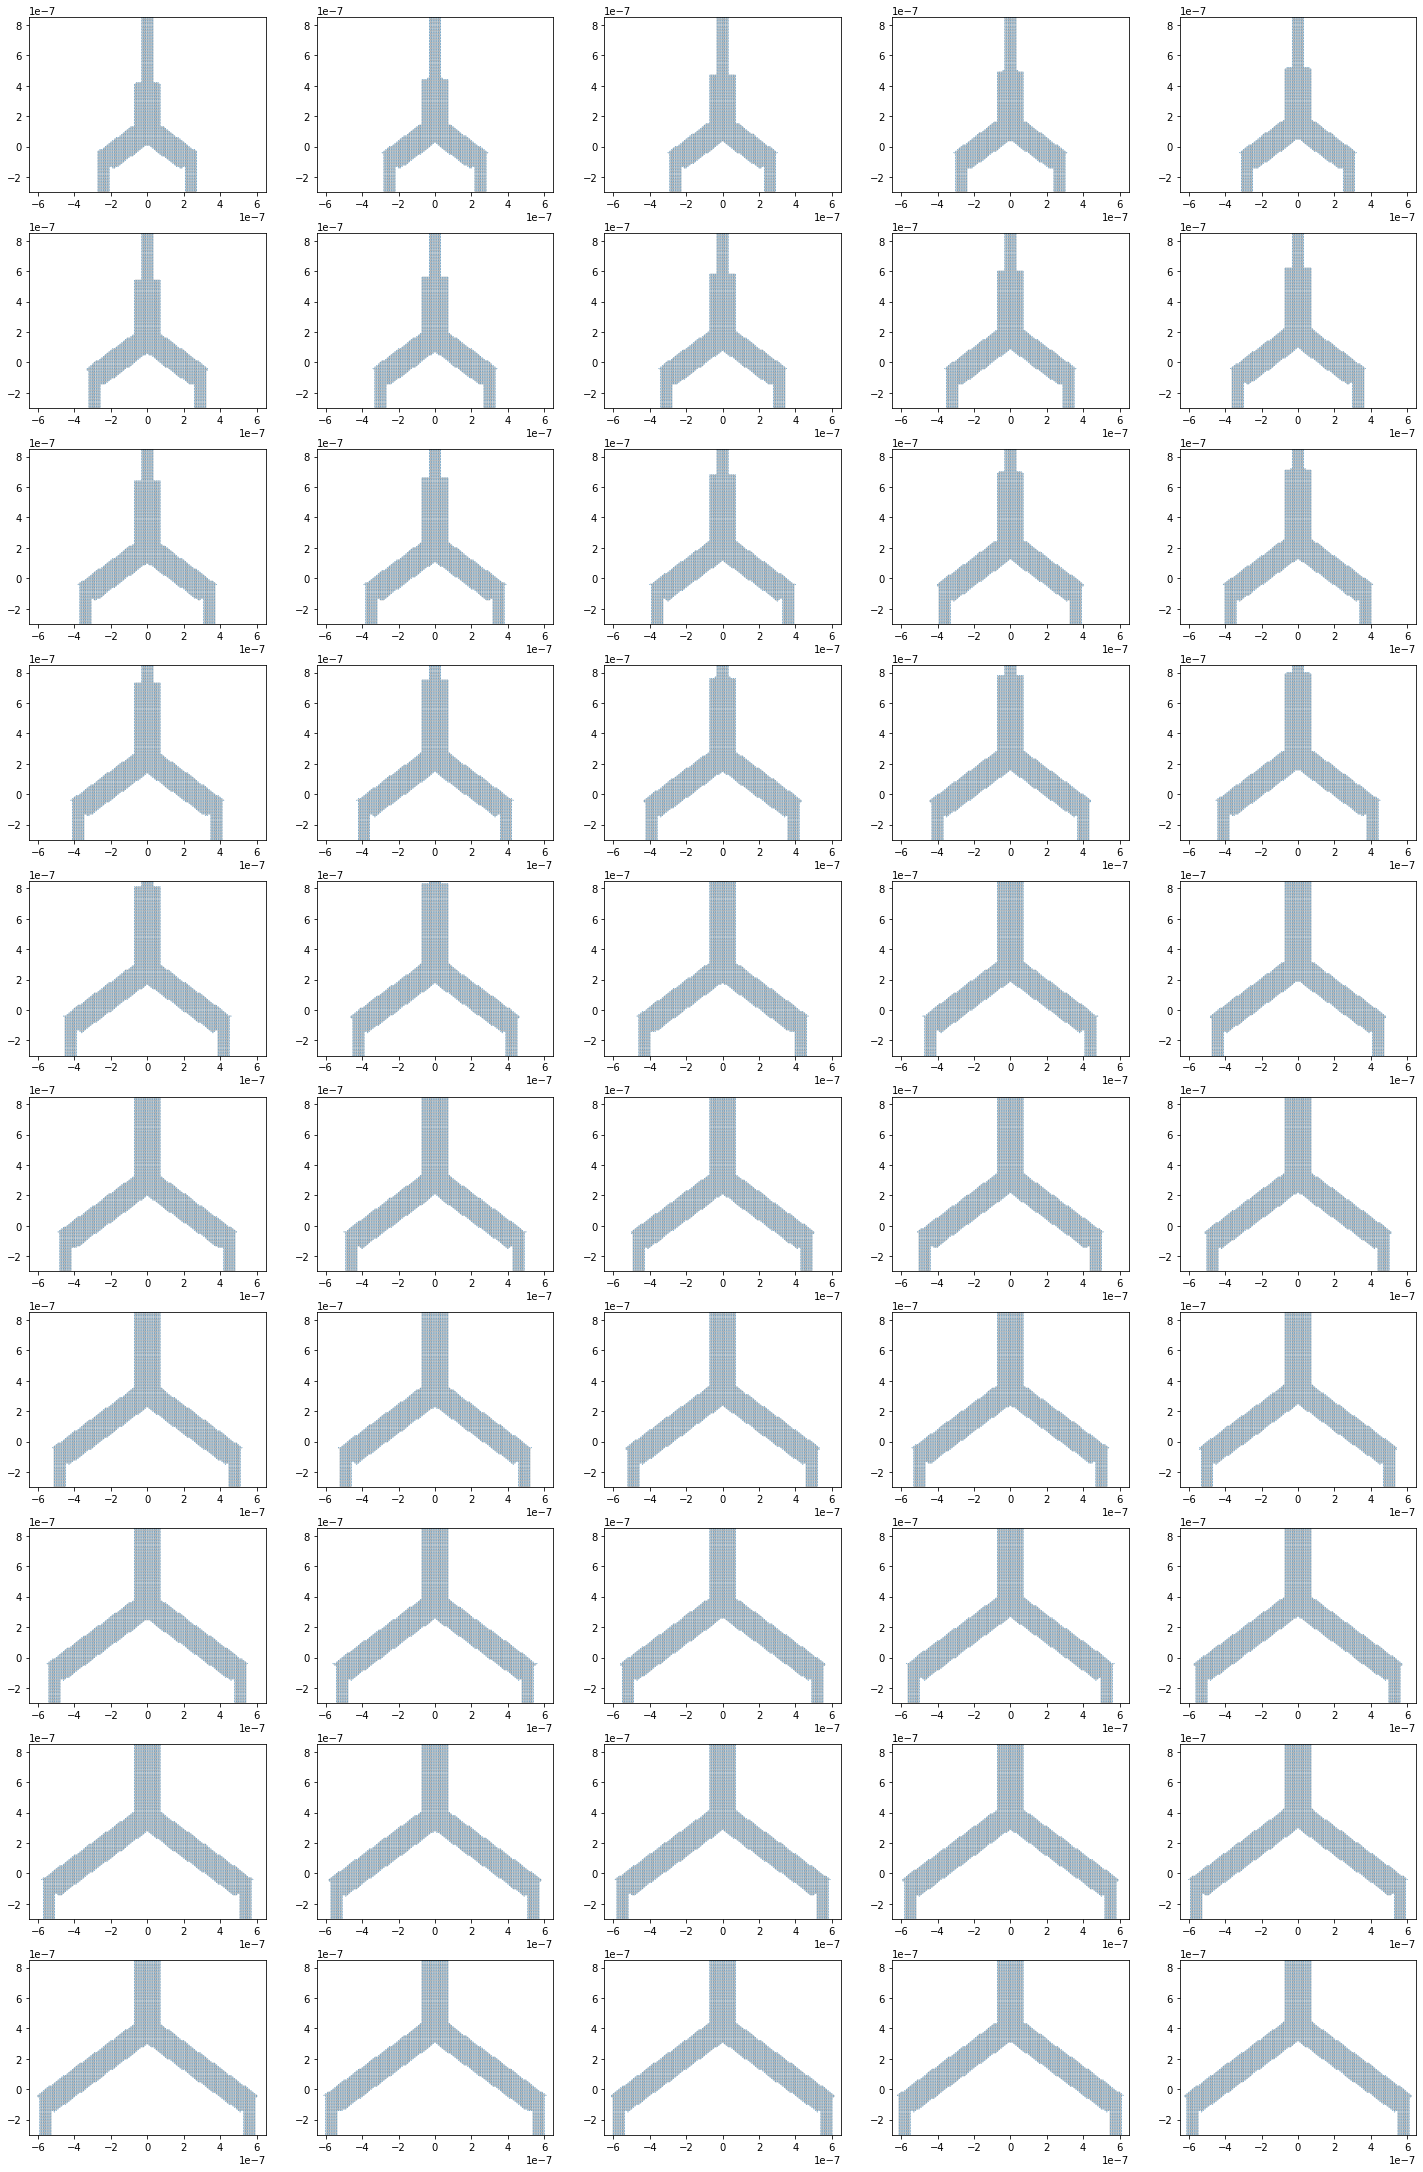

In [146]:
fig, ax = plt.subplots(ncols=5, nrows=10, figsize=(20, 30))
fig.tight_layout(h_pad=2, w_pad=2)
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-3e-7, 8.5e-7)
    axes.set_xlim(-6.5e-7, 6.5e-7)
    #axes.set_title(r'$R=$'+str(np.round(radius[i], 1)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [147]:
max_phis = max_phases(geometries=tjs)
path = directory_path + '/phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/748b753f19bd4ceea1cddd19afd5c700/status


In [148]:
path = directory_path + 'phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

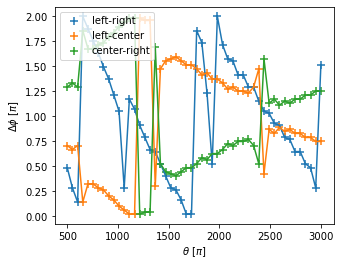

In [149]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(areas, level)
    ax.scatter(areas, level, label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\Delta \phi$ [$\pi$]')
ax.legend(loc='upper left')
plt.savefig(directory_path+'triangle_one_side_phase_relation.pdf')

In [150]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [35]:
%%time

index = 0 # single band calculation
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)


with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e18e57428bb343f9a8cb6f8d2593635e/status


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.9/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.9/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.9/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_handshak

CPU times: user 30.1 s, sys: 714 ms, total: 30.8 s
Wall time: 4min 5s


In [151]:
%%time
for index in range(7):

    args = []

    for i in range(n_geometries):
        for mu in mus_qd:
            for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                args.append([i, mu, param])

    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    path = directory_path + '/band_'+str(index)+'th.pickle'
    with open(path, 'wb') as file:
        pickle.dump(result, file)

Dashboard MBS coupling band 0: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/b975019b067e49fb8bb6c320b2032fe2/status
Dashboard MBS coupling band 1: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/d90720ad81d444089c9766bfc1b7e0c2/status
Dashboard MBS coupling band 2: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/1e01fbb4963c49ad9fb02ebb0c81f13a/status
Dashboard MBS coupling band 3: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/8765b23771ee40b18dc72d3b96d3328a/status
Dashboard MBS coupling band 4: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/3314c3963a9b4df39048226326ddd649/status
Dashboard MBS coupling band 5: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/da9b0b6921b2440582a5096daffdbf57/status
Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/fb3288c00faa4745bf242a10e54bc8b5/status
CPU ti

# Y shaped cavity angle

In [180]:
angle = np.pi*0.23
area = 1000*a**2
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": 0*a,
    "w_v": 15*a,
    "A": area
}

In [181]:
n_geometries = 25
angles = np.linspace(0.05, 0.3, n_geometries)
geometries=angles

In [182]:
mus_qd = np.linspace(-1e-3, 3e-3, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/y_shaped_angle/'

In [183]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/y_shaped_angle/’: File exists


256

## Calculation

In [184]:
tjs = []
for i in range(n_geometries):
    geometry.update(angle=angles[i]*np.pi)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

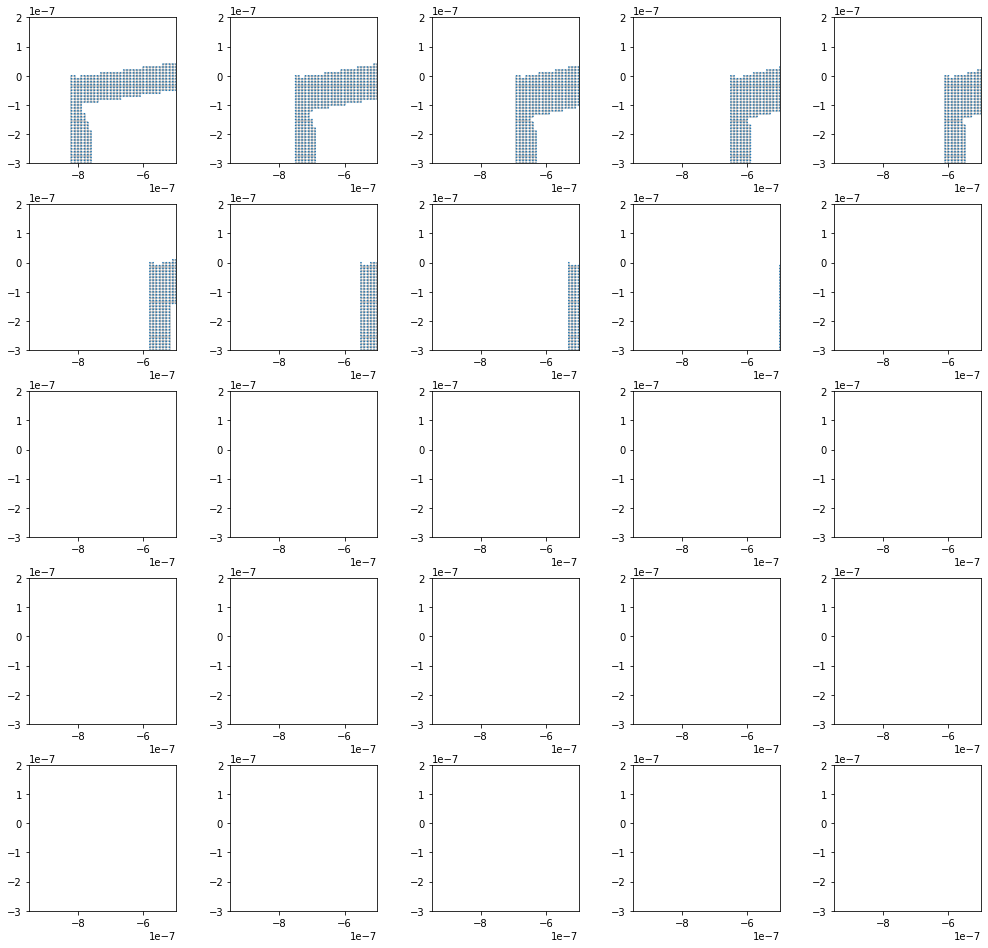

In [185]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(14, 13))
fig.tight_layout(h_pad=2, w_pad=2)
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-3e-7, 2e-7)
    axes.set_xlim(-9.5e-7, -5e-7)
    #axes.set_title(r'$R=$'+str(np.round(radius[i], 1)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [186]:
max_phis = max_phases(geometries=tjs)
path = directory_path + '/phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e4c2de5b5061405596cfb030f403eef1/status


In [187]:
path = directory_path + 'phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

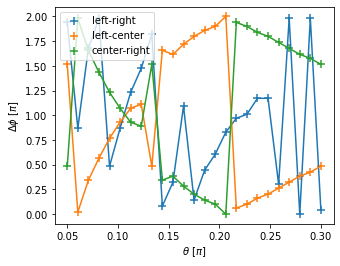

In [188]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(angles, level)
    ax.scatter(angles, level, label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_ylabel(r'$\Delta \phi$ [$\pi$]')
ax.legend(loc='upper left')
plt.savefig(directory_path+'triangle_one_side_phase_relation.pdf')

In [189]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [35]:
%%time

index = 0 # single band calculation
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)


with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/area_1400_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e18e57428bb343f9a8cb6f8d2593635e/status


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.9/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.9/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.9/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_handshak

CPU times: user 30.1 s, sys: 714 ms, total: 30.8 s
Wall time: 4min 5s


In [190]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)

        result = args_db.map(wrap).compute()

        path = directory_path + '/band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/51859ef4780643f0931b73f2c292d889/status
CPU times: user 9min 30s, sys: 15.6 s, total: 9min 46s
Wall time: 46min 51s


# Rectangular strip cavity

In [348]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 130*a
}

In [349]:
n_geometries = 20
distances = np.linspace(10*a, 50*a, n_geometries)

In [350]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/rectangle_wires/'

## Calculation

In [351]:
tjs = []
for distance in distances:
    geometry.update(centers=[distance, -distance])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

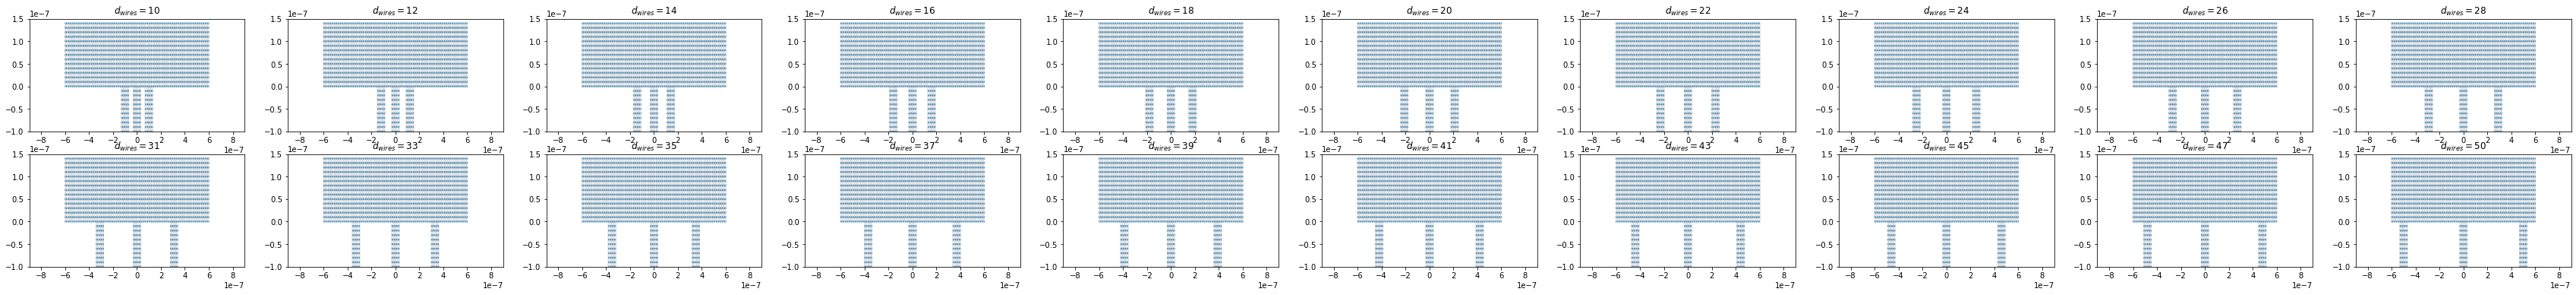

In [352]:
fig, ax = plt.subplots(ncols=int(n_geometries/2), nrows=2, figsize=(3*n_geometries, 6))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1e-7, 1.5e-7)
    axes.set_title(r'$d_{wires}=$'+str(int(distances[i]/a)))
    axes.set_xlim(-9e-7, 9e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [479]:
max_phis = max_phases(geometries=tjs)
path = directory_path + '/L_15_W_120_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [353]:
path = directory_path + '/L_15_W_120_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

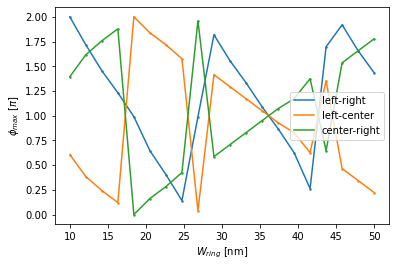

In [354]:
i = 0
for level in max_phis.T:
    plt.plot(1e8*distances, level, label=titles[i])
    plt.scatter(1e8*distances, level, s=2)
    i += 1
plt.xlabel(r'$W_{ring}$ [nm]')
plt.ylabel(r'$\phi_{max}$ [$\pi$]')
plt.legend()

In [355]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [356]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/rectangle_wires/’: File exists


256

In [458]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)

In [459]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/L_15_W_120_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/98165773374d4fe8be3edc40c7d95f72/status
CPU times: user 1min 7s, sys: 1.78 s, total: 1min 8s
Wall time: 8min


In [357]:
%%time
for index in range(7):

    args = []

    for i in range(n_geometries):
        for mu in mus_qd:
            for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                args.append([i, mu, param])

    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    path = directory_path + '/L_15_W_120_band_'+str(index)+'th.pickle'
    with open(path, 'wb') as file:
        pickle.dump(result, file)

Dashboard MBS coupling band 0: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/4ee904a7c7a94b7aba12ae2701a53545/status
Dashboard MBS coupling band 1: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/05229248125d4265816780b830ce8aca/status
Dashboard MBS coupling band 2: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/1e42499063c747828b40539b8e8cd327/status
Dashboard MBS coupling band 3: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/189159692d73498599a5aa5d34e10247/status
Dashboard MBS coupling band 4: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/afc60bf218e74843aecc64ffde13256c/status
Dashboard MBS coupling band 5: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/af538790d55a42d9a19cbc1d941683e1/status
Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/64230e0c15744c19835e954b5f084e25/status
CPU ti

## Selected cases

### $d_{wires} = 270$ [nm]

In [478]:
d_wires = 27*a

geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 154*a,
    "centers": [-d_wires, d_wires]
}

In [188]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


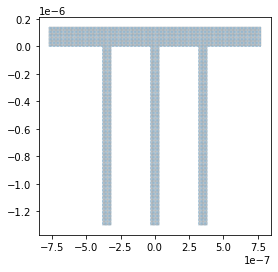

In [189]:
kwant.plot(trijunction);

In [193]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-0.001, 0.001, 100)

In [194]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [195]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_d_350.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e1715e4243094c4e80ec760ba66f2df7/status


# Rectangular strip change length cavity

In [191]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 154*a
#    "centers": [-21*a, 21*a]
}

In [192]:
n_geometries = 40
widths = np.linspace(50*a, 170*a, n_geometries)

In [193]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/rectangle_width/'

## Calculation

In [194]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/rectangle_width/’: File exists


256

In [195]:
tjs = []
for W in widths:
    geometry.update(W=W)
    geometry.update(centers=[-W/2+6*a, W/2-6*a])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

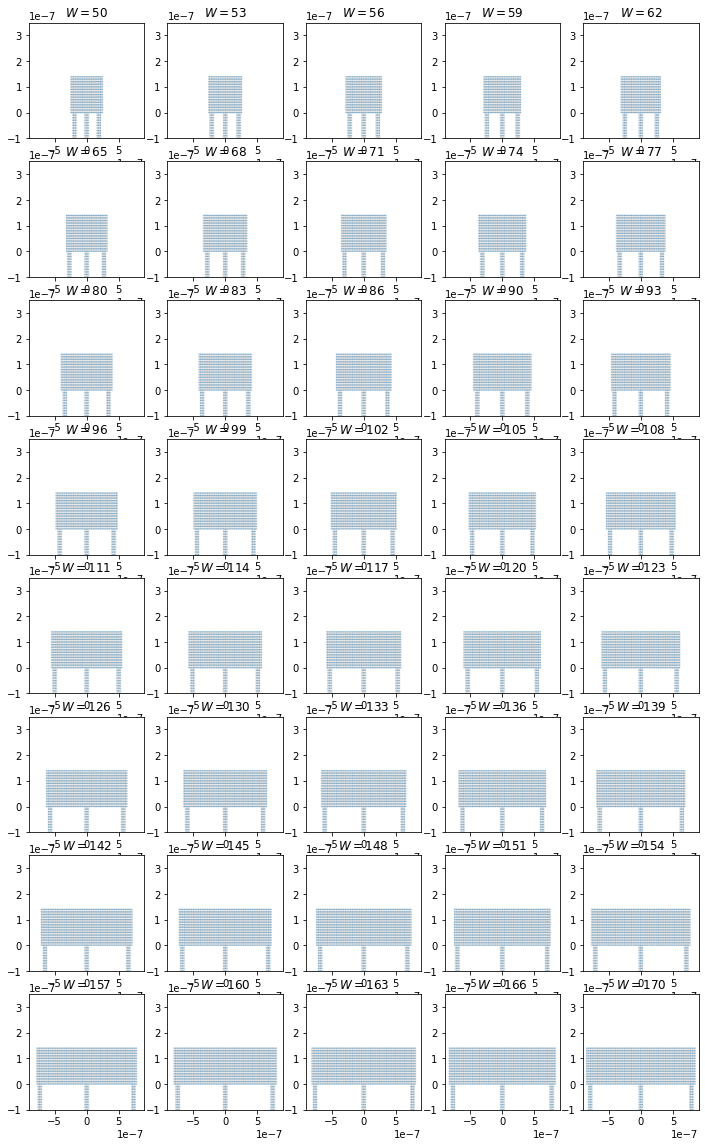

In [196]:
fig, ax = plt.subplots(ncols=5, nrows=8, figsize=(12, 20))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1e-7, 3.5e-7)
    axes.set_title(r'$W=$'+str(int(widths[i]/a)))
    axes.set_xlim(-9e-7, 9e-7)
    i += 1

In [413]:
%%time
max_phis = max_phases(geometries=tjs)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/3a4d856f742046c2986039a8de7197ec/status
CPU times: user 2min 19s, sys: 7.22 s, total: 2min 26s
Wall time: 9min 22s


In [414]:
path = directory_path + 'W_15_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

In [197]:
path = directory_path + '/W_15_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

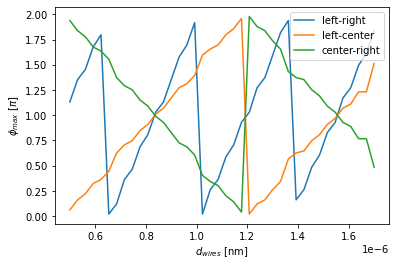

In [198]:
i = 0
for level in max_phis.T:
    plt.plot(widths, level, label=titles[i])
    i += 1
plt.xlabel(r'$d_{wires}$ [nm]')
plt.ylabel(r'$\phi_{max}$ [$\pi$]')
plt.legend()

In [199]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [200]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/rectangle_width/’: File exists


256

In [419]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)

In [420]:
%%time
with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/9909c2ac556d47dba19100559f60774e/status
CPU times: user 2min 7s, sys: 3.68 s, total: 2min 11s
Wall time: 11min 34s


In [201]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)
        result = args_db.map(wrap).compute()

        path = directory_path + '/band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/01a60ad3a00542e3aa7630c83b0b2441/status
CPU times: user 15min 4s, sys: 29.4 s, total: 15min 33s
Wall time: 1h 21min 23s


## Selected cases

### $d_{wires} = 350$ [nm]

In [187]:
d_wires = 35*a

geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 154*a,
    "centers": [-d_wires, d_wires]
}

In [188]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


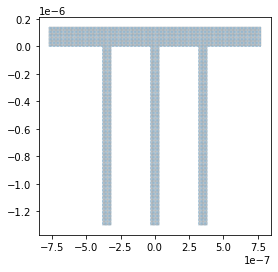

In [189]:
kwant.plot(trijunction);

In [193]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-0.001, 0.001, 100)

In [194]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [195]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_d_350.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e1715e4243094c4e80ec760ba66f2df7/status


# Rectangular cavity

In [271]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 154*a,
    "centers": [-50*a, 50*a]
}

In [272]:
n_geometries = 20
lengths = np.linspace(20*a, 100*a, n_geometries)

In [273]:
mus_qd = np.linspace(-0.002, 0.002, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/rectangle_length/'

## Calculation

In [274]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/rectangle_length/’: File exists


256

In [275]:
tjs = []
for L in lengths:
    geometry.update(L=L)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

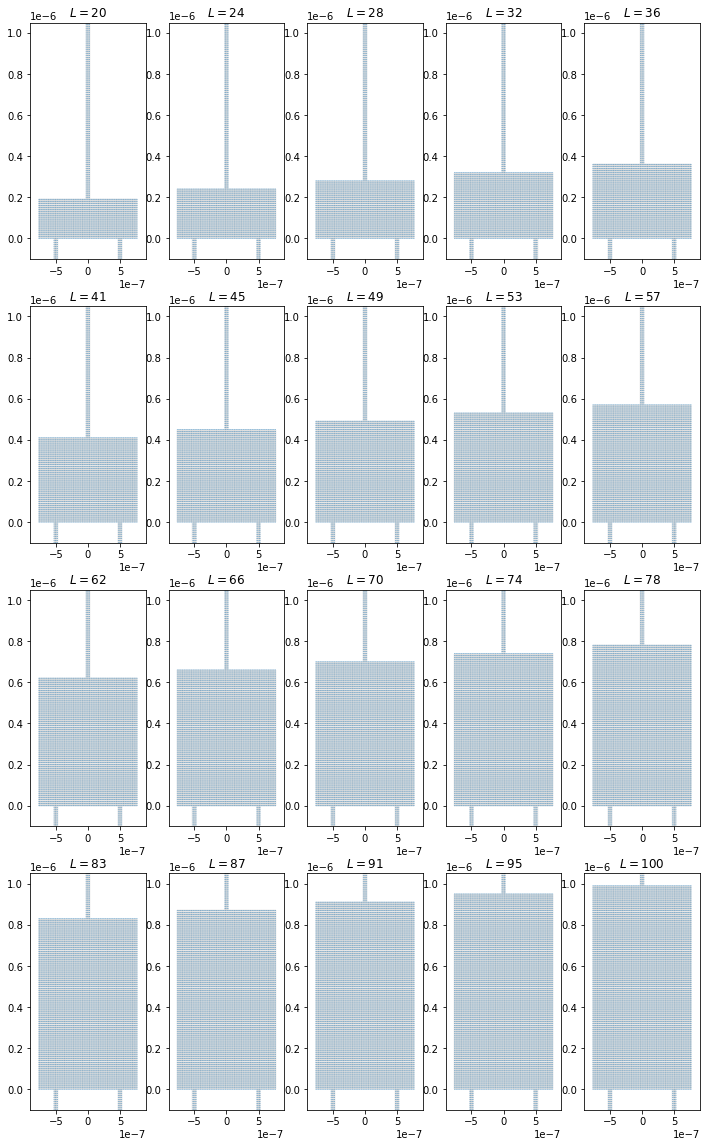

In [276]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(12, 20))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1e-7, 10.5e-7)
    axes.set_title(r'$L=$'+str(int(lengths[i]/a)))
    axes.set_xlim(-9e-7, 9e-7)
    i += 1

In [277]:
%%time
max_phis = max_phases(geometries=tjs, mu_qd0=-1.5e-3)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/3d906193cd4e45eebc842d9fd7c2206c/status
CPU times: user 2min 15s, sys: 6.62 s, total: 2min 22s
Wall time: 43min 17s


In [278]:
path = directory_path + 'W_154_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

In [279]:
path = directory_path + '/W_154_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

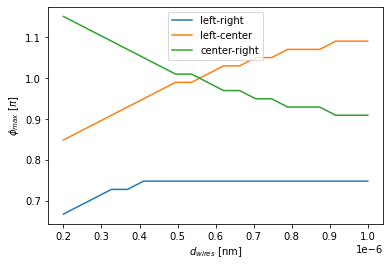

In [280]:
i = 0
for level in max_phis.T:
    plt.plot(lengths, level, label=titles[i])
    i += 1
plt.xlabel(r'$d_{wires}$ [nm]')
plt.ylabel(r'$\phi_{max}$ [$\pi$]')
plt.legend()

In [281]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [282]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/rectangle_length/’: File exists


256

In [51]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)

In [52]:
%%time
with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/W_154_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/d7f453fc525647de9c8dbc2fef98df99/status
CPU times: user 2min 10s, sys: 8.12 s, total: 2min 18s
Wall time: 23min 36s


In [283]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)
        result = args_db.map(wrap).compute()

        path = directory_path + '/W_154_band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/eee4e9a4acaf49ef9fbd0e1315a5f11f/status
CPU times: user 15min 9s, sys: 53.5 s, total: 16min 2s
Wall time: 2h 47min 50s


# Circular cavity radius

In [1022]:
angle = np.pi/6
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": 0*a,
    "w_v": 11*a
}

In [1023]:
n_geometries = 20
radius = np.linspace(12, 32, n_geometries)
areas = np.linspace(250, 800, n_geometries)
geometries=radius

In [1024]:
mus_qd = np.linspace(-1e-3, 3e-3, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/circle/'

## Calculation

In [21]:
tjs = []
for i in range(n_geometries):
    geometry.update(radius=radius[i]*a)
    geometry.update(A=areas[i]*a**2)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

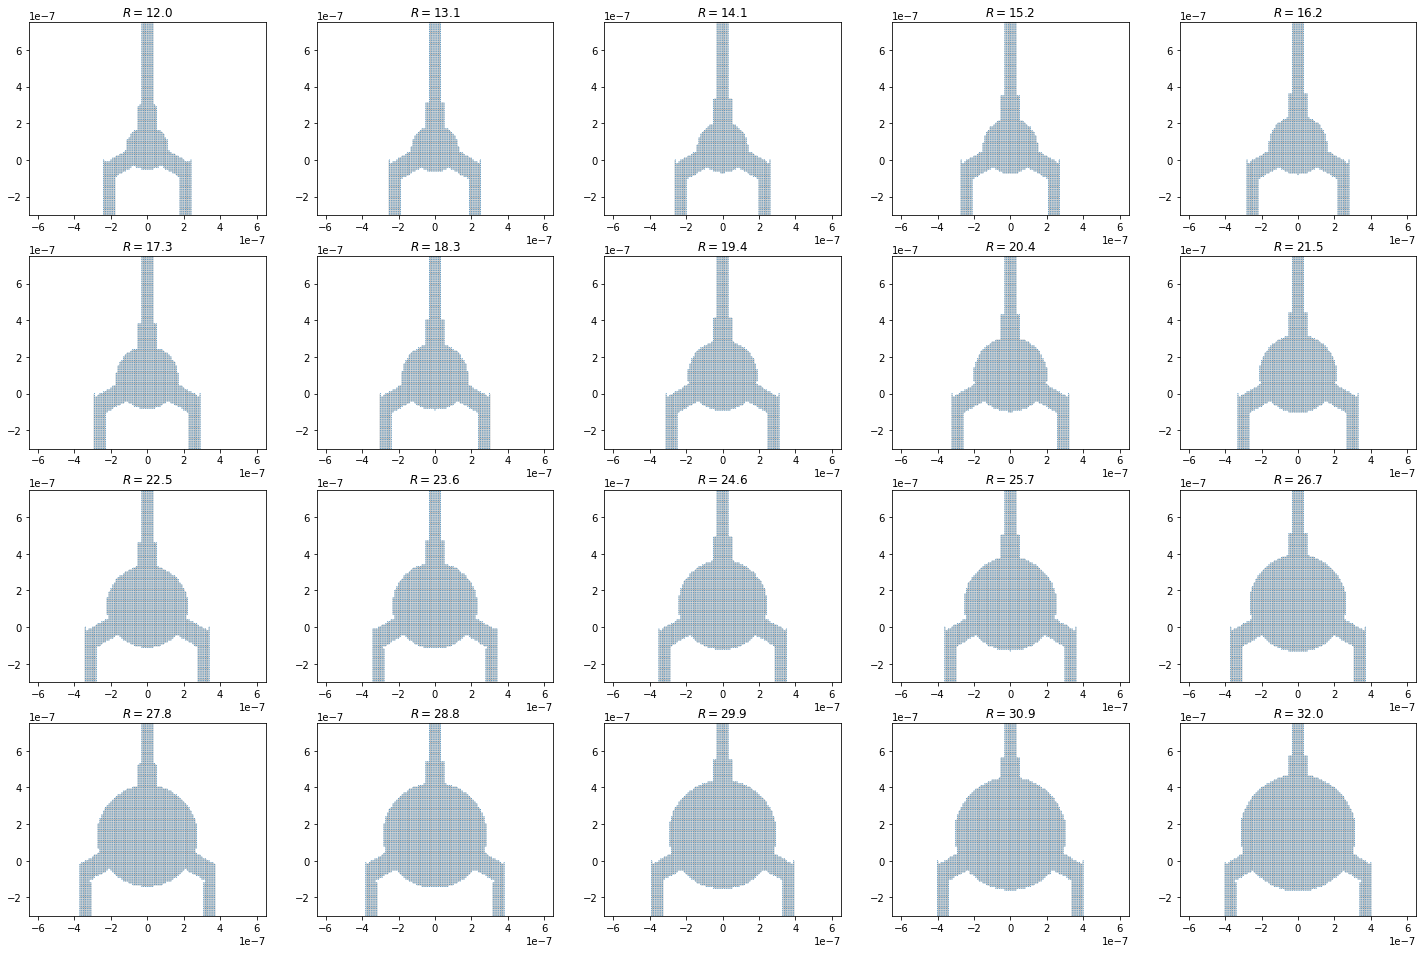

In [22]:
fig, ax = plt.subplots(ncols=int(n_geometries/4), nrows=4, figsize=(20, 13))
fig.tight_layout(h_pad=2, w_pad=2)
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-3e-7, 7.5e-7)
    axes.set_xlim(-6.5e-7, 6.5e-7)
    axes.set_title(r'$R=$'+str(np.round(radius[i], 1)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [26]:
max_phis = max_phases(geometries=tjs)
path = directory_path + '/phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/908916cb6d1b4eb1a8bd6baddb316d69/status


In [693]:
path = directory_path + '/phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

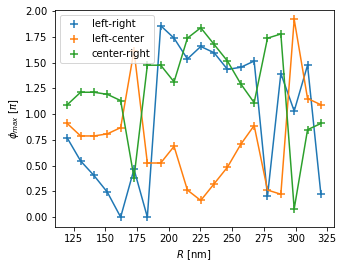

In [697]:
fig, ax = plt.subplots(figsize=(5, 4))
i = 0
for level in max_phis.T:
    ax.plot(10*radius, level)
    ax.scatter(10*radius, level, label=titles[i], marker='+', s=70)
    i += 1
ax.set_xlabel(r'$R$ [nm]')
ax.set_ylabel(r'$\phi_{max}$ [$\pi$]')
ax.legend(loc='upper left')
plt.savefig(directory_path+'circle_phase_relation.pdf')

In [34]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [35]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/circle/’: File exists


256

In [18]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)

In [19]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/9e1e72401d554bf9a98bd57988ff5c2f/status
CPU times: user 1min 5s, sys: 2.01 s, total: 1min 7s
Wall time: 8min 3s


In [36]:
%%time
for index in range(7):

    args = []

    for i in range(n_geometries):
        for mu in mus_qd:
            for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                args.append([i, mu, param])

    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Dashboard MBS coupling band "+str(index)+": http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    path = directory_path + '/band_'+str(index)+'th.pickle'
    with open(path, 'wb') as file:
        pickle.dump(result, file)

Dashboard MBS coupling band 0: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/7548675cc1a64c25a0958f3ad3f364a6/status
Dashboard MBS coupling band 1: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e63e61cce9f34d179c1a3520b13deb8f/status
Dashboard MBS coupling band 2: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e9d8f44f537848d38039cdc49cf6c1c6/status
Dashboard MBS coupling band 3: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/af79df366d854bbeb9575d4bf56649c9/status
Dashboard MBS coupling band 4: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/af9d68a18aa24680abe3ab9c47f1c6da/status
Dashboard MBS coupling band 5: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/5738b404906641e0b12a9efa111de730/status
Dashboard MBS coupling band 6: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/4ef0ef0794cb475fb36f77ff02b6335c/status
CPU ti

## Selected cases

### $r = 200$ [nm]

In [283]:
angle = np.pi*0.23
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": radius[8]*a,
    "w_v": 11*a,
    "A": areas[8]*a**2,
}

NameError: name 'radius' is not defined

In [ ]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

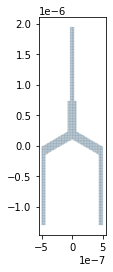

In [284]:
kwant.plot(trijunction);

In [57]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-1e-3, 3e-3, 100)

In [58]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [59]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_r_20.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/a6d8d1146cc9430f83a3549d93129e20/status


# Circular cavity angles

In [249]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": 25*a,
    "w_v": 11*a,
    "A": 700*a**2,
}

In [260]:
n_geometries = 25
angles = np.linspace(0.05, 0.3, n_geometries)
areas = np.linspace(400, 500, n_geometries)
geometries=angles

In [261]:
mus_qd = np.linspace(-1e-3, 3e-3, 100)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/circle_angles/'

In [262]:
os.system('mkdir '+directory_path)

mkdir: cannot create directory ‘../data/manuscript/circle_angles/’: File exists


256

## Calculation

In [263]:
tjs = []
for i in range(n_geometries):
    geometry.update(A=areas[i]*a**2)
    geometry.update(angle=angles[i]*np.pi)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

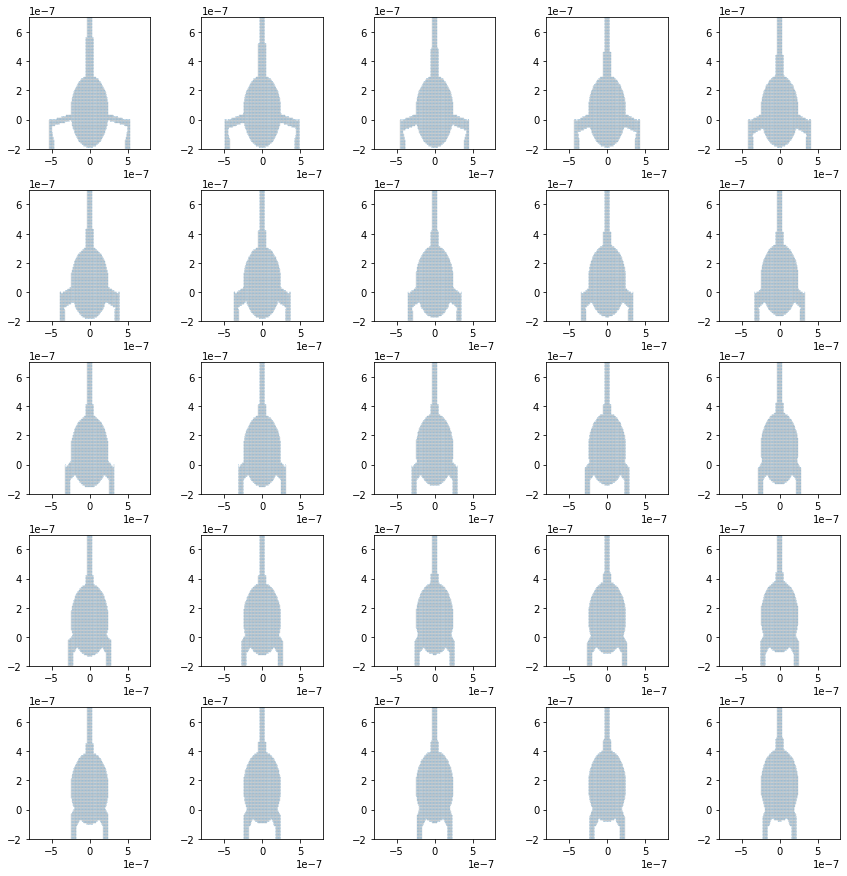

In [264]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(12, 12))
fig.tight_layout(h_pad=2, w_pad=2)
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-2e-7, 7e-7)
    axes.set_xlim(-8e-7, 8e-7)
    i += 1

In [217]:
max_phis = max_phases(geometries=tjs)
path = directory_path + '/R_25_angles_phis.pickle'
with open(path, 'wb') as file:
    pickle.dump(max_phis, file)

Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/afee8d1d49fd490b8134f12068abd4f0/status


In [218]:
path = directory_path + '/R_25_angles_phis.pickle'
with open(path, 'rb') as data:
    max_phis = pickle.load(data)

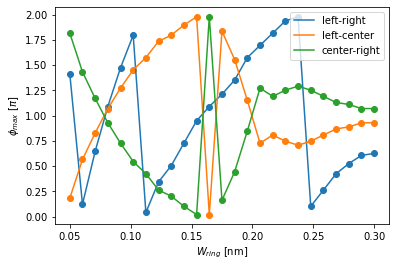

In [220]:
i = 0
for level in max_phis.T:
    plt.plot(angles, level, label=titles[i])
    plt.scatter(angles, level)
    i += 1
plt.xlabel(r'$W_{ring}$ [nm]')
plt.ylabel(r'$\phi_{max}$ [$\pi$]')
plt.legend()

In [221]:
eigen = sl.solver(geometries=tjs, n=n, key=key)


def wrap(args):
    return eigen(*args)

In [222]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/circle_angles/’: File exists


256

In [92]:
index = 0
args = []

for i in range(n_geometries):
    for mu in mus_qd:
        for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
            args.append([i, mu, param])

args_db = db.from_sequence(args, npartitions=40)

In [93]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/R_20_band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e0938eff4c0841beb4a560cebba0b2be/status
CPU times: user 25.4 s, sys: 670 ms, total: 26 s
Wall time: 3min 4s


In [223]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for index in range(7):

        args = []

        for i in range(n_geometries):
            for mu in mus_qd:
                for param in sl.finite_coupling_parameters(index=index, phis=np.pi*max_phis[i]):
                    args.append([i, mu, param])

        args_db = db.from_sequence(args, npartitions=40)
        result = args_db.map(wrap).compute()

        path = directory_path + '/R_25_band_'+str(index)+'th.pickle'
        with open(path, 'wb') as file:
            pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/e3382c18b6e34f779d25334fb9a6e07f/status


KeyboardInterrupt: 

## Selected cases

### $r = 200$ [nm] and $\theta = 0.28 \pi$ and $area = 350$

In [139]:
angle = angles[2]*np.pi
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": radius[8]*a,
    "w_v": 11*a,
    "A": areas[8]*a**2,
}

In [140]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


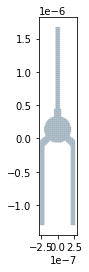

In [141]:
kwant.plot(trijunction);

In [142]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-1e-3, 2e-3, 100)
tjs = [[trijunction, f_params]]

In [143]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [144]:
# execute calculation
index = 0
phis = np.pi*max_phis[2]
params = sl.finite_coupling_parameters(index=index, phis=phis)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_R_20.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/061bb74b1e1949bdabdb5e2515d232c6/status


### $r = 200$ [nm] and $\theta = 0.28 \pi$ and $area = 350$

In [534]:
angle = angles[0]*np.pi
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": radius[8]*a,
    "w_v": 11*a,
    "A": areas[8]*a**2,
}

In [535]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


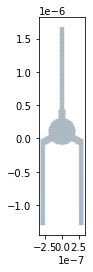

In [536]:
kwant.plot(trijunction);

In [537]:
n = 6
key = 'mu_qd'
mus_qd = np.linspace(-1e-3, 2e-3, 100)
tjs = [[trijunction, f_params]]

In [538]:
eigen = sl.solver(geometries=[[trijunction, f_params]], n=n, key=key, eigenvecs=True)


def wrap(args):
    return eigen(*args)

In [539]:
# execute calculation
index = 0
phis = np.pi*max_phis[0]
params = sl.finite_coupling_parameters(index=index, phis=phis)

args = list(it.product([0], mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/ens_wfs_R_20_angle_2.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/f729dd44776c4e23ac8e2c4b60056b69/status
